In [1]:
from math import ceil
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import os

import matplotlib.pyplot as plt

import torch.utils.data as td
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
from collections import defaultdict

import numpy as np
# from scipy.signal import savgol_filter
import time
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

from sklearn.manifold import TSNE
import pickle

import json
from PIL import Image as PilImage
from PIL import ImageOps

import torch
from torchvision import transforms
import pandas as pd
from tqdm import tqdm


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision
import matplotlib
import tqdm
import PIL
import sklearn
import pickle
import math
import collections

In [3]:
print(pd.__version__)
print(torch.__version__)
print(torchvision.__version__)
print(tqdm.__version__)
print(PIL.__version__)
print(json.__version__)
#print(pickle.__version__)
print(sklearn.__version__)
print(np.__version__)
#print(time.__version__)
print(matplotlib.__version__)
from platform import python_version
print(python_version())

2.0.3
2.0.0
0.15.1
4.66.1
9.5.0
2.0.9
1.2.2
1.23.5
3.7.2
3.10.12


In [6]:
pcancer_path = "/kaggle/input/comp6321-project-datasets/Dataset 2/Dataset 2/Prostate Cancer"
pcancer_subDirectories = os.listdir(pcancer_path)

ccancer_path = "/kaggle/input/comp6321-project-datasets/Dataset 1/Dataset 1/Colorectal Cancer "
ccancer_subDirectories = os.listdir(pcancer_path)

afaces_path = "/kaggle/input/comp6321-project-datasets/Dataset 3/Dataset 3/Animal Faces"
afaces_subDirectories = os.listdir(afaces_path)

model1_path = "/kaggle/input/models/COMP6321_ResNet_Task1_CancerDataset_Model_Final_HyperParamaterTuning8.pth"
plot_img_path = '/kaggle/input/comp6321-project-datasets/Dataset 2/Dataset 2/Prostate Cancer/tumor/tu.1001.jpg'
output_path = "/kaggle/working"

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
def read_label(subDirectories):
    print(subDirectories)
    enu = range(len(subDirectories))
    labels_map={}
    for enu,subDirectory in enumerate(subDirectories):
        labels_map.update({enu:subDirectory})
    print(labels_map)
    print("The number of labels in the dataset = %s"% len(labels_map))
    print("The \'%s\' device is being used to process the dataset"%device)
    return labels_map

pcancer_labels_map = read_label(pcancer_subDirectories)
afaces_labels_map = read_label(afaces_subDirectories)

['tumor', 'gland', 'nongland']
{0: 'tumor', 1: 'gland', 2: 'nongland'}
The number of labels in the dataset = 3
The 'cuda' device is being used to process the dataset
['dog', 'wild', 'cat']
{0: 'dog', 1: 'wild', 2: 'cat'}
The number of labels in the dataset = 3
The 'cuda' device is being used to process the dataset


In [9]:
def displayImages(t_dataset,imageFlag):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    if imageFlag==0:
        figure.suptitle("Images before preprocessing")
    else:
        figure.suptitle("Images after preprocessing")   
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(t_dataset), size=(1,)).item()
        img, label = t_dataset[sample_idx]
        img=np.array(img).transpose((1,2,0))
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze())
    print("\n\n\n################################################\n\n\n")
    plt.show()

In [10]:
def add_border(image):
    border_size = 1  # Set the border size in pixels
    border_color = (0, 0, 255)
    height, width, channels = image.shape
    bordered_image = np.ones((height + 2 * border_size, width + 2 * border_size, channels), dtype=np.uint8)*255
    bordered_image[border_size:border_size + height, border_size:border_size + width] = image
    #bordered_image[0:border_size, :] = border_color  # Top border
    #bordered_image[-border_size:, :] = border_color  # Bottom border
    #bordered_image[:, 0:border_size] = border_color  # Left border
    #bordered_image[:, -border_size:] = border_color  # Right border
    
    blue_channel =  np.pad(image[:, :, 0], pad_width=1, mode='constant', constant_values=0)
    green_channel = np.pad(image[:, :, 1], pad_width=1, mode='constant', constant_values=0)
    red_channel = np.pad(image[:, :, 2], pad_width=1, mode='constant', constant_values=0)
    return np.stack((blue_channel, green_channel, red_channel), axis=-1)

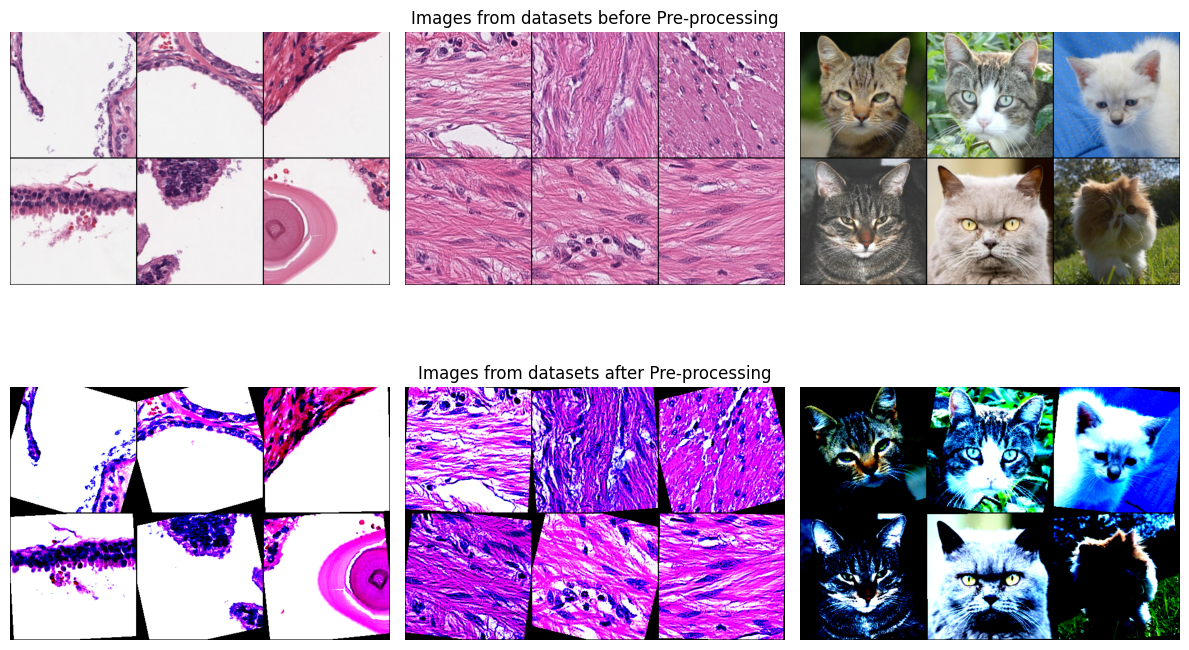

In [11]:
batch_size=32
input_size=(224,224)

data_dir_list = (pcancer_path,ccancer_path, afaces_path)
data_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.554, 0.450, 0.343],[0.231, 0.241, 0.241]),
    ])

dsets= []#
for pth in data_dir_list:
    prd = datasets.ImageFolder(pth,transform=transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor(),   
            ]))
    dsets.append(prd)
    pod = datasets.ImageFolder(pth,transform=data_transform)
    dsets.append(pod)

cols, rows = 2, 3
indices = []
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(3000, size=(1,)).item()
    indices.append(sample_idx)

border_size = 5  # Set the border size in pixels
border_color = 'black'

ds_images = []
for ds in dsets:
    ind = 0
    img, label = ds[indices[ind]]
    img = np.array(img).transpose((1,2,0))
    img = add_border(img)
    irow = img
    ind+=1
    for j in range(1,rows):
        img, label = ds[indices[ind]]
        #img = add_border(img) #ImageOps.expand(img, border=border_size, fill=border_color)
        img = np.array(img).transpose((1,2,0))
        img = add_border(img)
        irow = np.hstack((irow, img))
        ind+= 1

    images=[irow]
    for i in range(1,cols):
        img, label = ds[indices[ind]]
        #img = add_border(img) #ImageOps.expand(img, border=border_size, fill=border_color)
        img = np.array(img).transpose((1,2,0))
        img = add_border(img)
        irow = img
        ind+=1
        for j in range(1, rows):
            img, label = ds[indices[ind]]
            #img = add_border(img) #ImageOps.expand(img, border=border_size, fill=border_color)
            img = np.array(img).transpose((1,2,0))
            img = add_border(img)
            irow = np.hstack((irow, img))
            ind+= 1
        images.append(irow)

    prc_image = np.vstack(tuple(images))
    
    ds_images.append(prc_image)
    

plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
#plt.suptitle("Shared Title for Row 1", fontsize=16)
# Subplot 1
plt.subplot(2, 3, 1)
#plt.title('Subplot 1')
plt.imshow(ds_images[0])
plt.axis('off')
# Subplot 2
plt.subplot(2, 3, 2)
plt.title('Images from datasets before Pre-processing')
plt.imshow(ds_images[2])
plt.axis('off')
# Subplot 3
plt.subplot(2, 3, 3)
#plt.title('Subplot 3')
plt.imshow(ds_images[4])
plt.axis('off')
# Subplot 4
#plt.suptitle("Shared Title for Row 2", fontsize=16)
plt.subplot(2, 3, 4)
#plt.title('Subplot 4')
plt.imshow(ds_images[1])
plt.axis('off')
# Subplot 5
plt.subplot(2, 3, 5)
plt.title('Images from datasets after Pre-processing')
plt.imshow(ds_images[3])
plt.axis('off')
# Subplot 6
plt.subplot(2, 3, 6)
#plt.title('Subplot 6')
plt.imshow(ds_images[5])
plt.axis('off')
# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [12]:
def data_loader(data_dir_input,batch_sizeGiven,input_size,flag=0,test_split=1):
    
# Define dataset directory and transforms
    data_dir = data_dir_input #
  
    data_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.1,0.1,0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.554, 0.450, 0.343],[0.231, 0.241, 0.241]),
      ])


    if flag==1:
        test_temp_dataset = datasets.ImageFolder(data_dir,transform=transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor(),   
            ]))
        displayImages(test_temp_dataset,0)
        test_temp_dataset = datasets.ImageFolder(data_dir,transform=data_transform)
        displayImages(test_temp_dataset,1)

        data = datasets.ImageFolder(root=data_dir, transform=data_transform)
        # Define test dataset
        dataset_size = len(data)


    # Create a dictionary to store the number of images per class
        num_images_per_class = defaultdict(int)

    # Print the number of images per class
        for label, num_images in num_images_per_class.items():
            print(f"Class {label}: {num_images} images")
  

    # Define the number of classes and generate a list of colors
        num_classes = len(num_images_per_class)
        colors = plt.cm.Set1(np.linspace(0, 1, num_classes))
        # Plot the number of images per class as a bar plot
        plt.bar(num_images_per_class.keys(), num_images_per_class.values(), color=colors)
    
        # Add axis labels and title
        plt.xlabel("Class")
        plt.ylabel("Number of images")
        plt.title("Number of images per class in the dataset")

        # Create a legend
        labels = [f"Class {label}" for label in num_images_per_class.keys()]
        plt.legend([plt.bar(0, 0, color=colors[i])[0] for i in range(len(num_images_per_class))], labels,loc='center left', bbox_to_anchor=(1, 0.5))
        plt.rcParams["figure.figsize"] = (40,15)
        # Show the plot
        plt.show()
    
        return  

    data = datasets.ImageFolder(root=data_dir, transform=data_transform)
    test_loader = DataLoader(data, batch_size=batch_sizeGiven, shuffle=True, drop_last=False, num_workers=0,pin_memory=True)

    return test_loader

In [13]:
model1 = torch.load(model1_path)
model1 = torch.nn.Sequential(*(list(model1.children())[:-1]))
model1.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [14]:
#model2 = torch.load('/kaggle/input/models/COMP6321_ResNet_Task1_CancerDataset_Model_Final_TransferLearning0.pth')
model2 = models.resnet18(weights="IMAGENET1K_V1").to(device)
model2.fc = nn.Linear(512,len(pcancer_labels_map)).to(device) # fine tuning the last layer
model2 = torch.nn.Sequential(*(list(model2.children())[:-1]))
model2.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s] 


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [15]:
batch_size=32
inputDimension=(224,224)

In [16]:
def tSNE_plot(temporaryModel, test_loader):
    plt.rcParams.update({'font.size': 55})
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in test_loader:
            images, targets = data[0].to(device), data[1].to(device)
            outputs = temporaryModel(images)
            embeddings.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    
    #Flatten features due to Found array with dim 4. TSNE expected <= 2.
    embeddings = embeddings.reshape(embeddings.shape[0], -1)
    # Apply t-SNE for visualization
    tsne = TSNE(n_components=2, perplexity=30, random_state=0)
    embeddings_tsne = tsne.fit_transform(embeddings)

      # Plot t-SNE embeddings
    plt.figure(figsize=(30,15))

    for i in range(len(labels_map)):
        plt.scatter(embeddings_tsne[labels==i,0], embeddings_tsne[labels==i,1], label=f'Class {i}')
    legend = plt.legend()
    for handle in legend.legend_handles:
        handle.set_sizes([400])
    plt.title('t-SNE Embeddings for the Data')
    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.show()
    plt.rcParams.update({'font.size': 10})

# Plot T_SNE before Feature Extraction**

**Plot T_SNE before For Prostate Cancer Dataset using Model 1**

['tumor', 'gland', 'nongland']
{0: 'tumor', 1: 'gland', 2: 'nongland'}
The number of labels in the dataset = 3
The 'cuda' device is being used to process the dataset


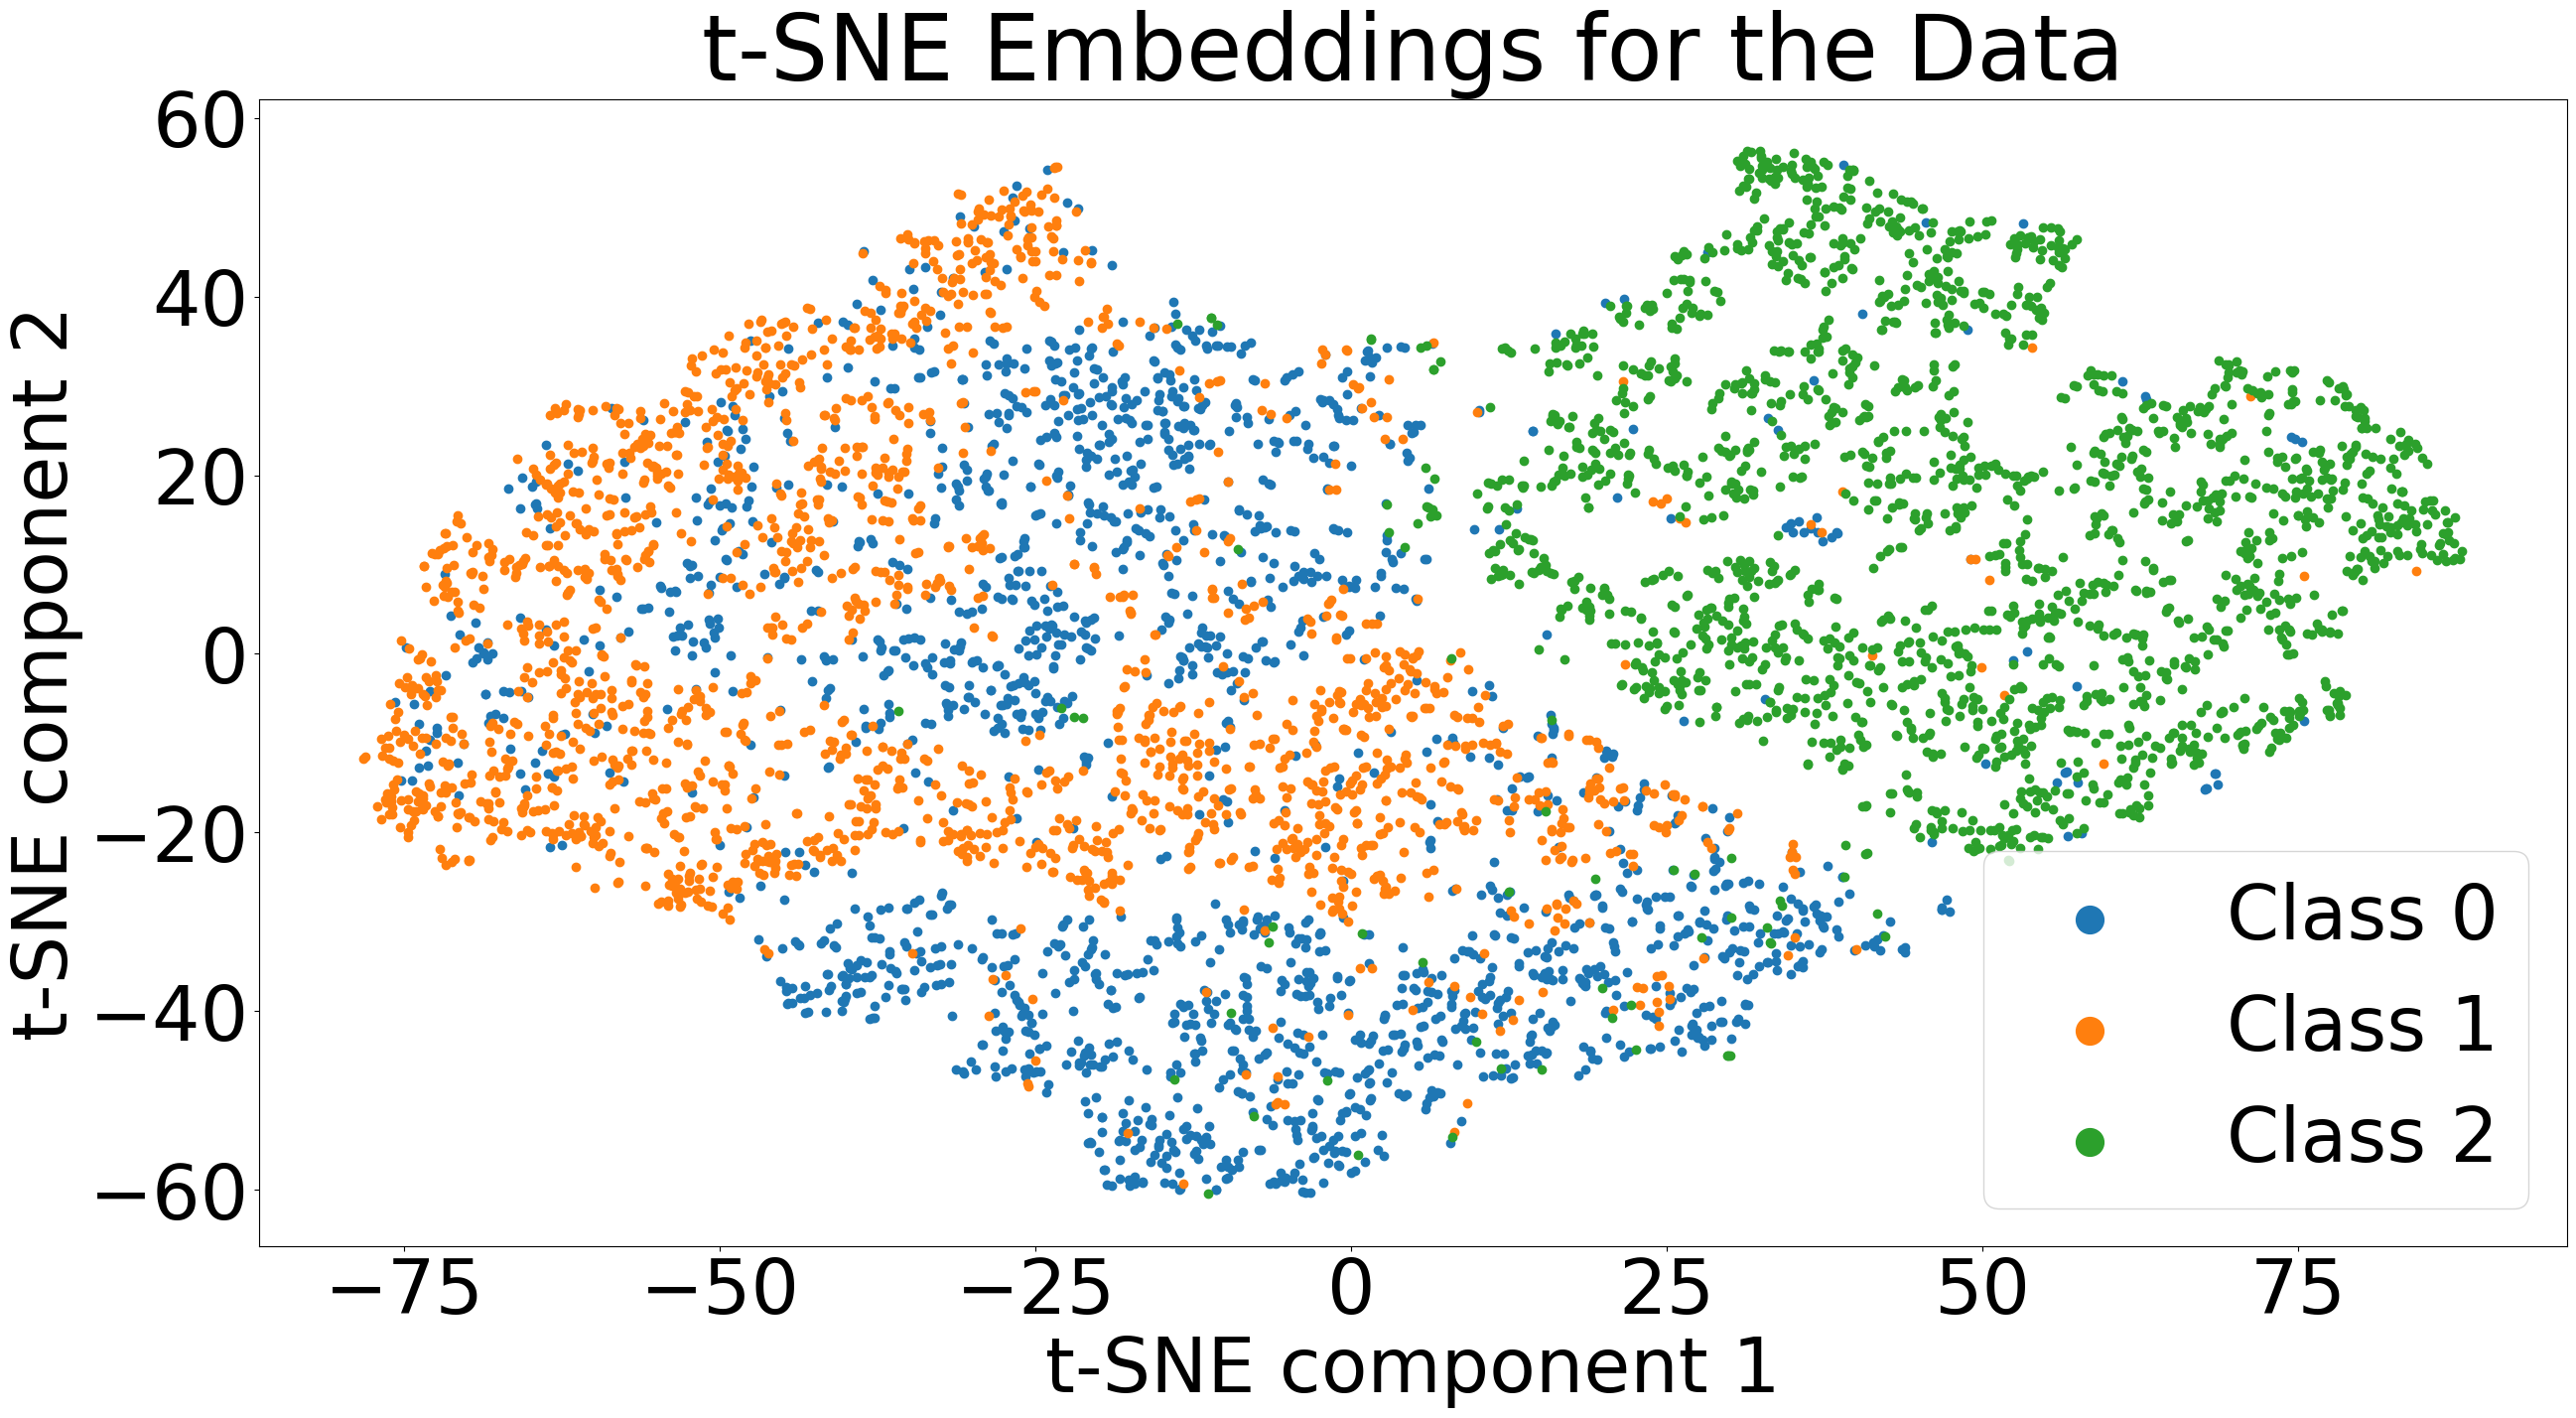

In [17]:
#Plot t-SNE before Feature Extraction
labels_map = read_label(pcancer_subDirectories)
#afaces_labels_map = read_label(afaces_subDirectories)
test_loader = data_loader(pcancer_path,batch_size, inputDimension)
tSNE_plot(model1, test_loader)

**Plot T_SNE before For Prostate Cancer Dataset using Model 2**

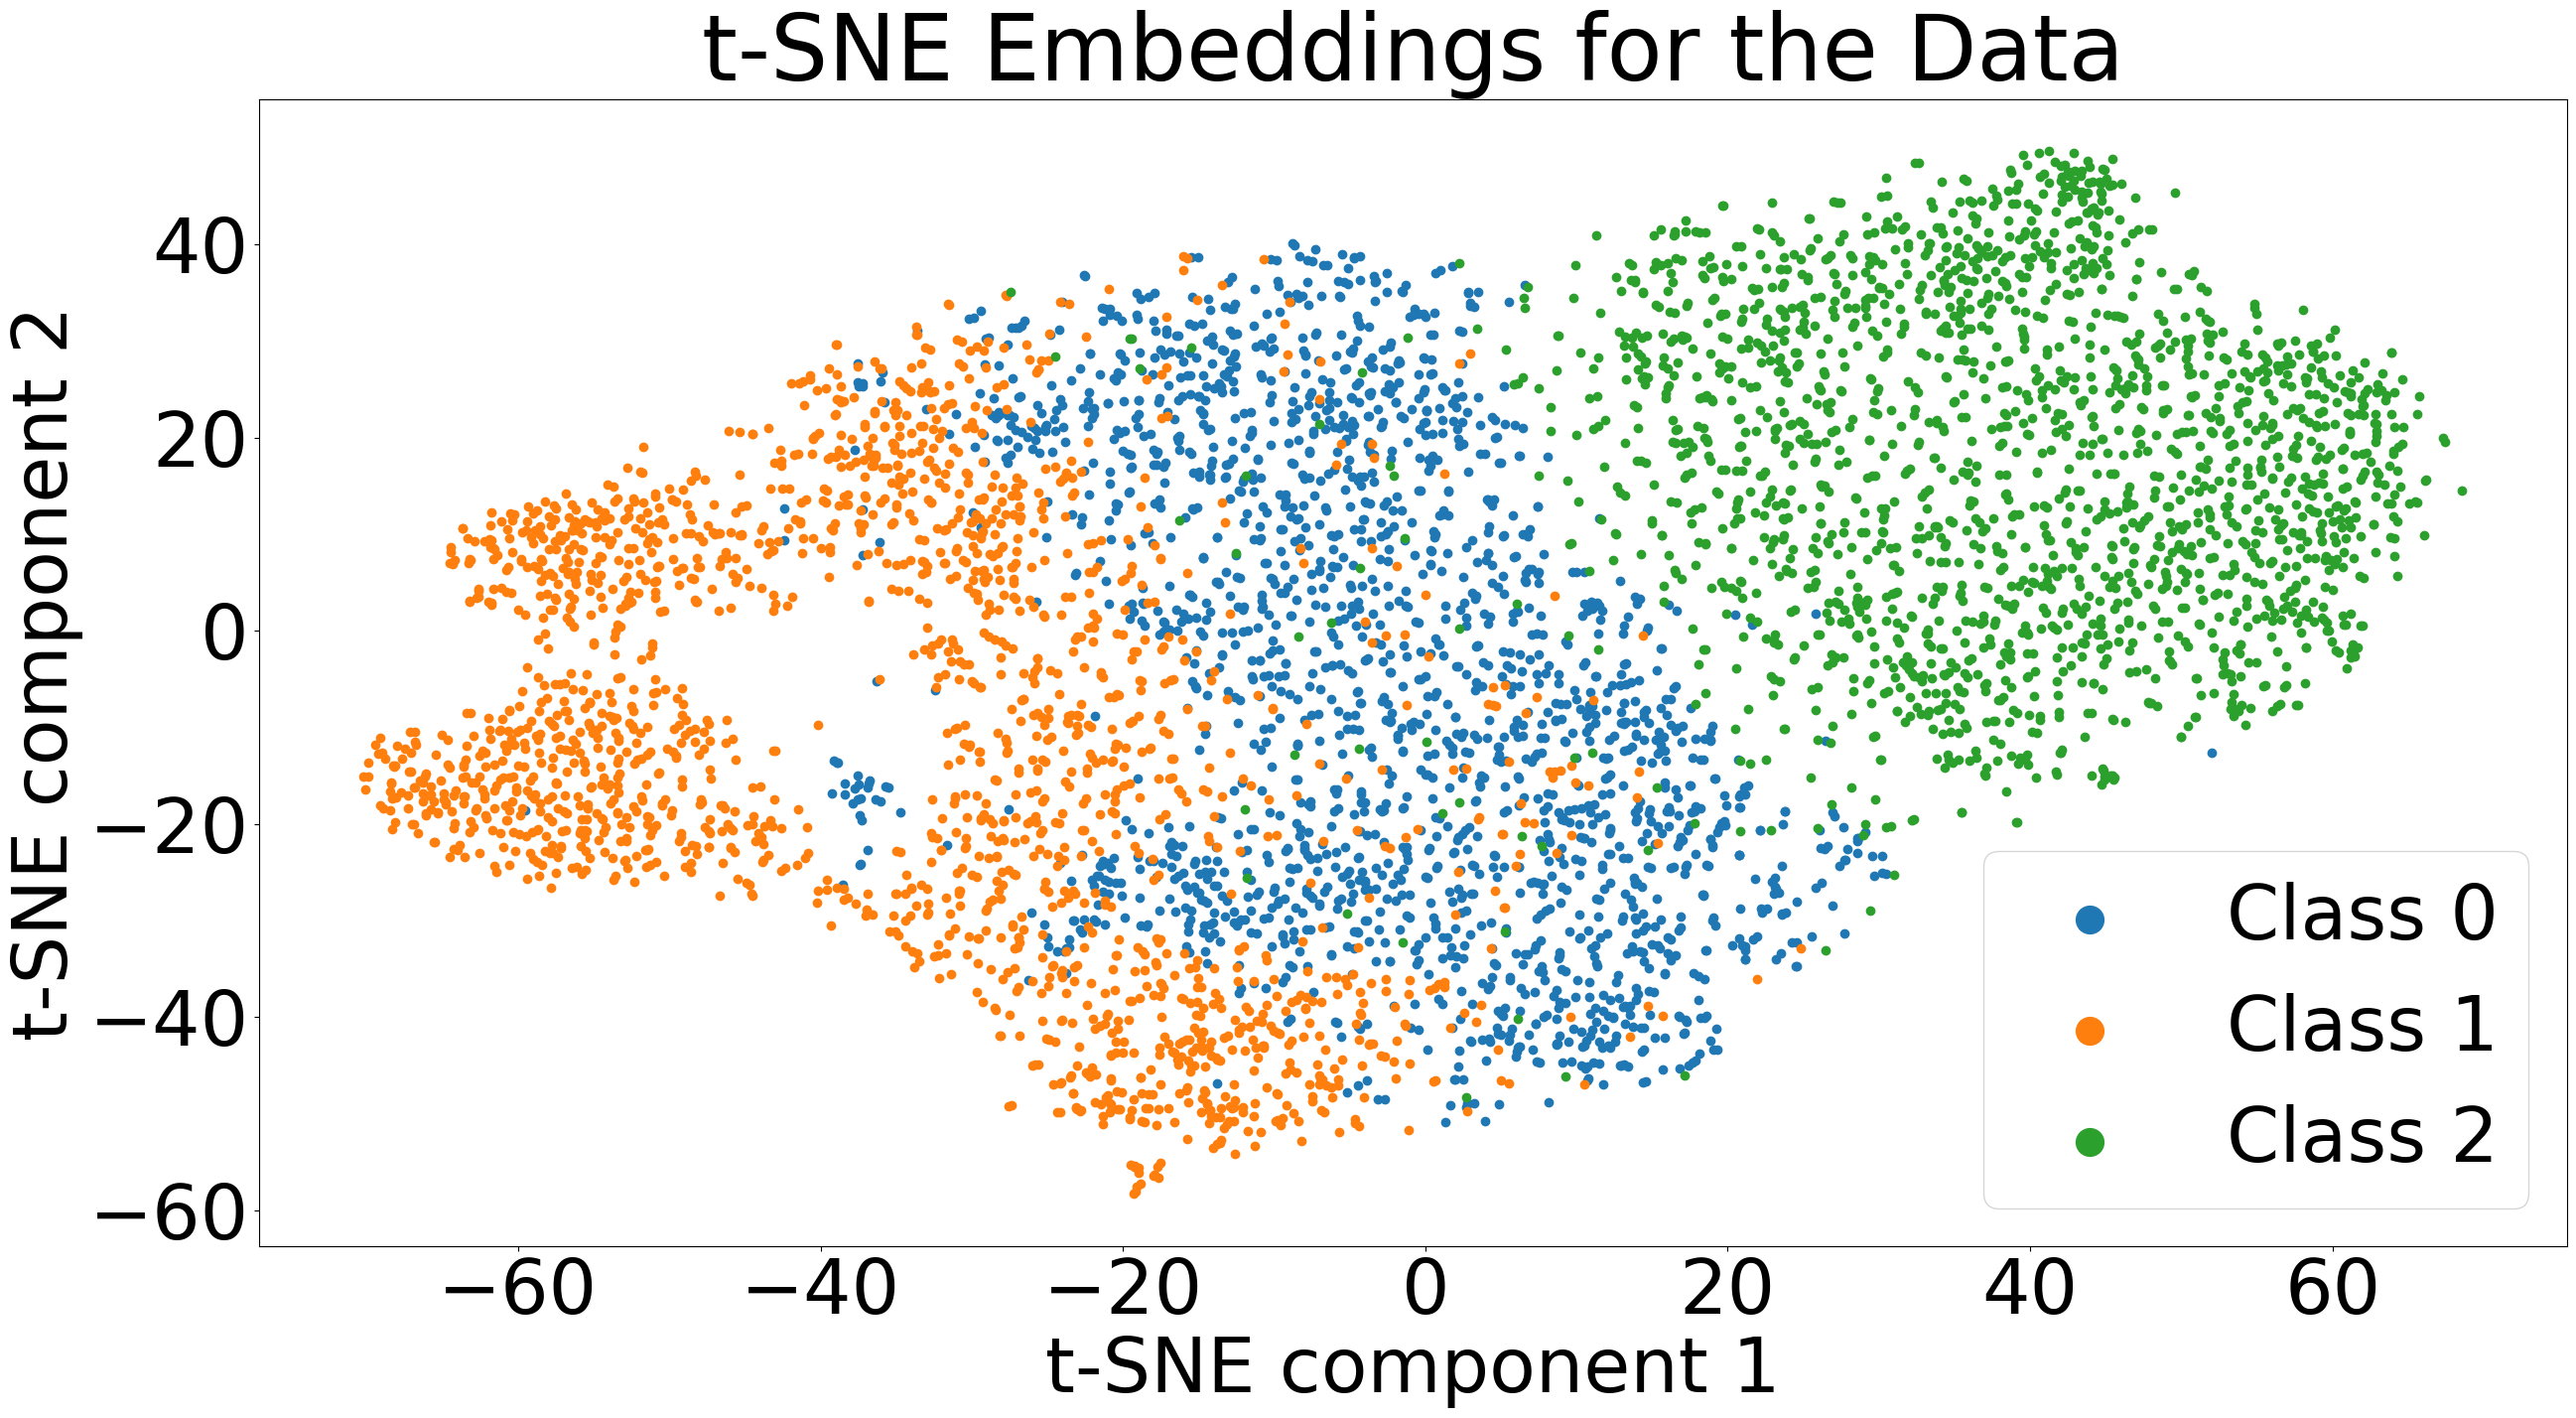

In [18]:
tSNE_plot(model2, test_loader)

**Plot T_SNE before For Animal Faces Dataset using Model 1**

['dog', 'wild', 'cat']
{0: 'dog', 1: 'wild', 2: 'cat'}
The number of labels in the dataset = 3
The 'cuda' device is being used to process the dataset


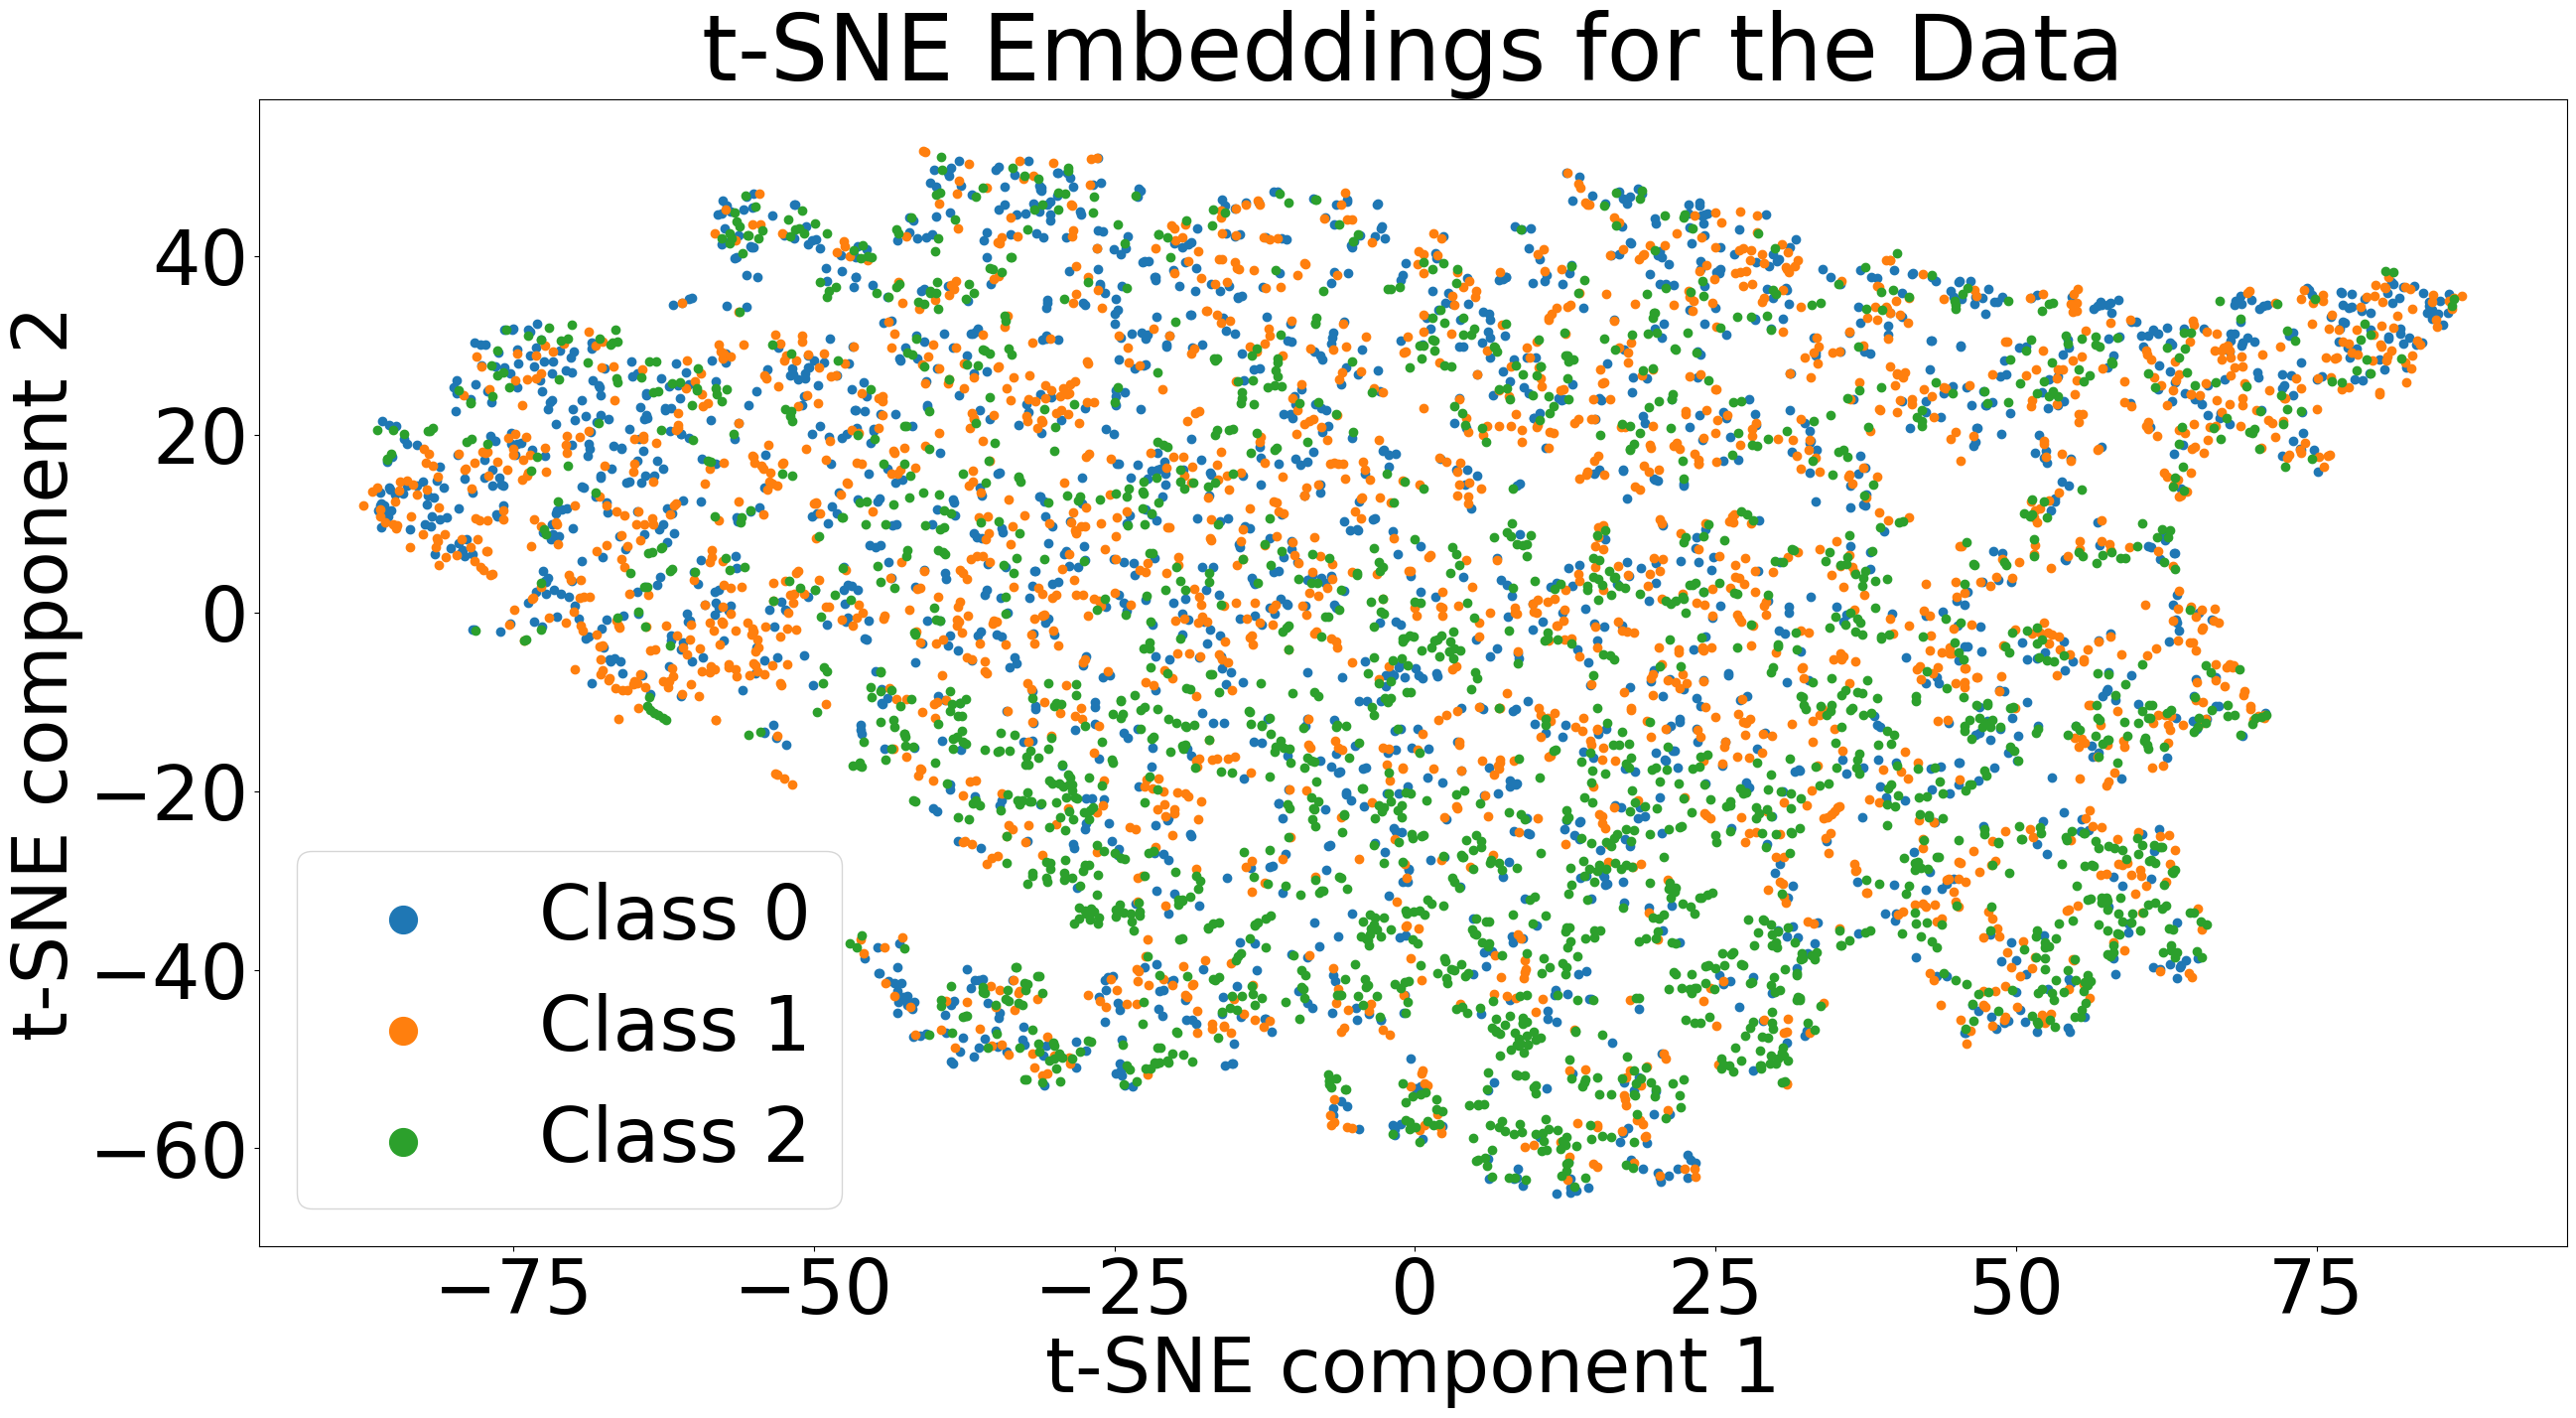

In [19]:
labels_map = read_label(afaces_subDirectories)
test_loader = data_loader(afaces_path,batch_size, inputDimension)
tSNE_plot(model1, test_loader)

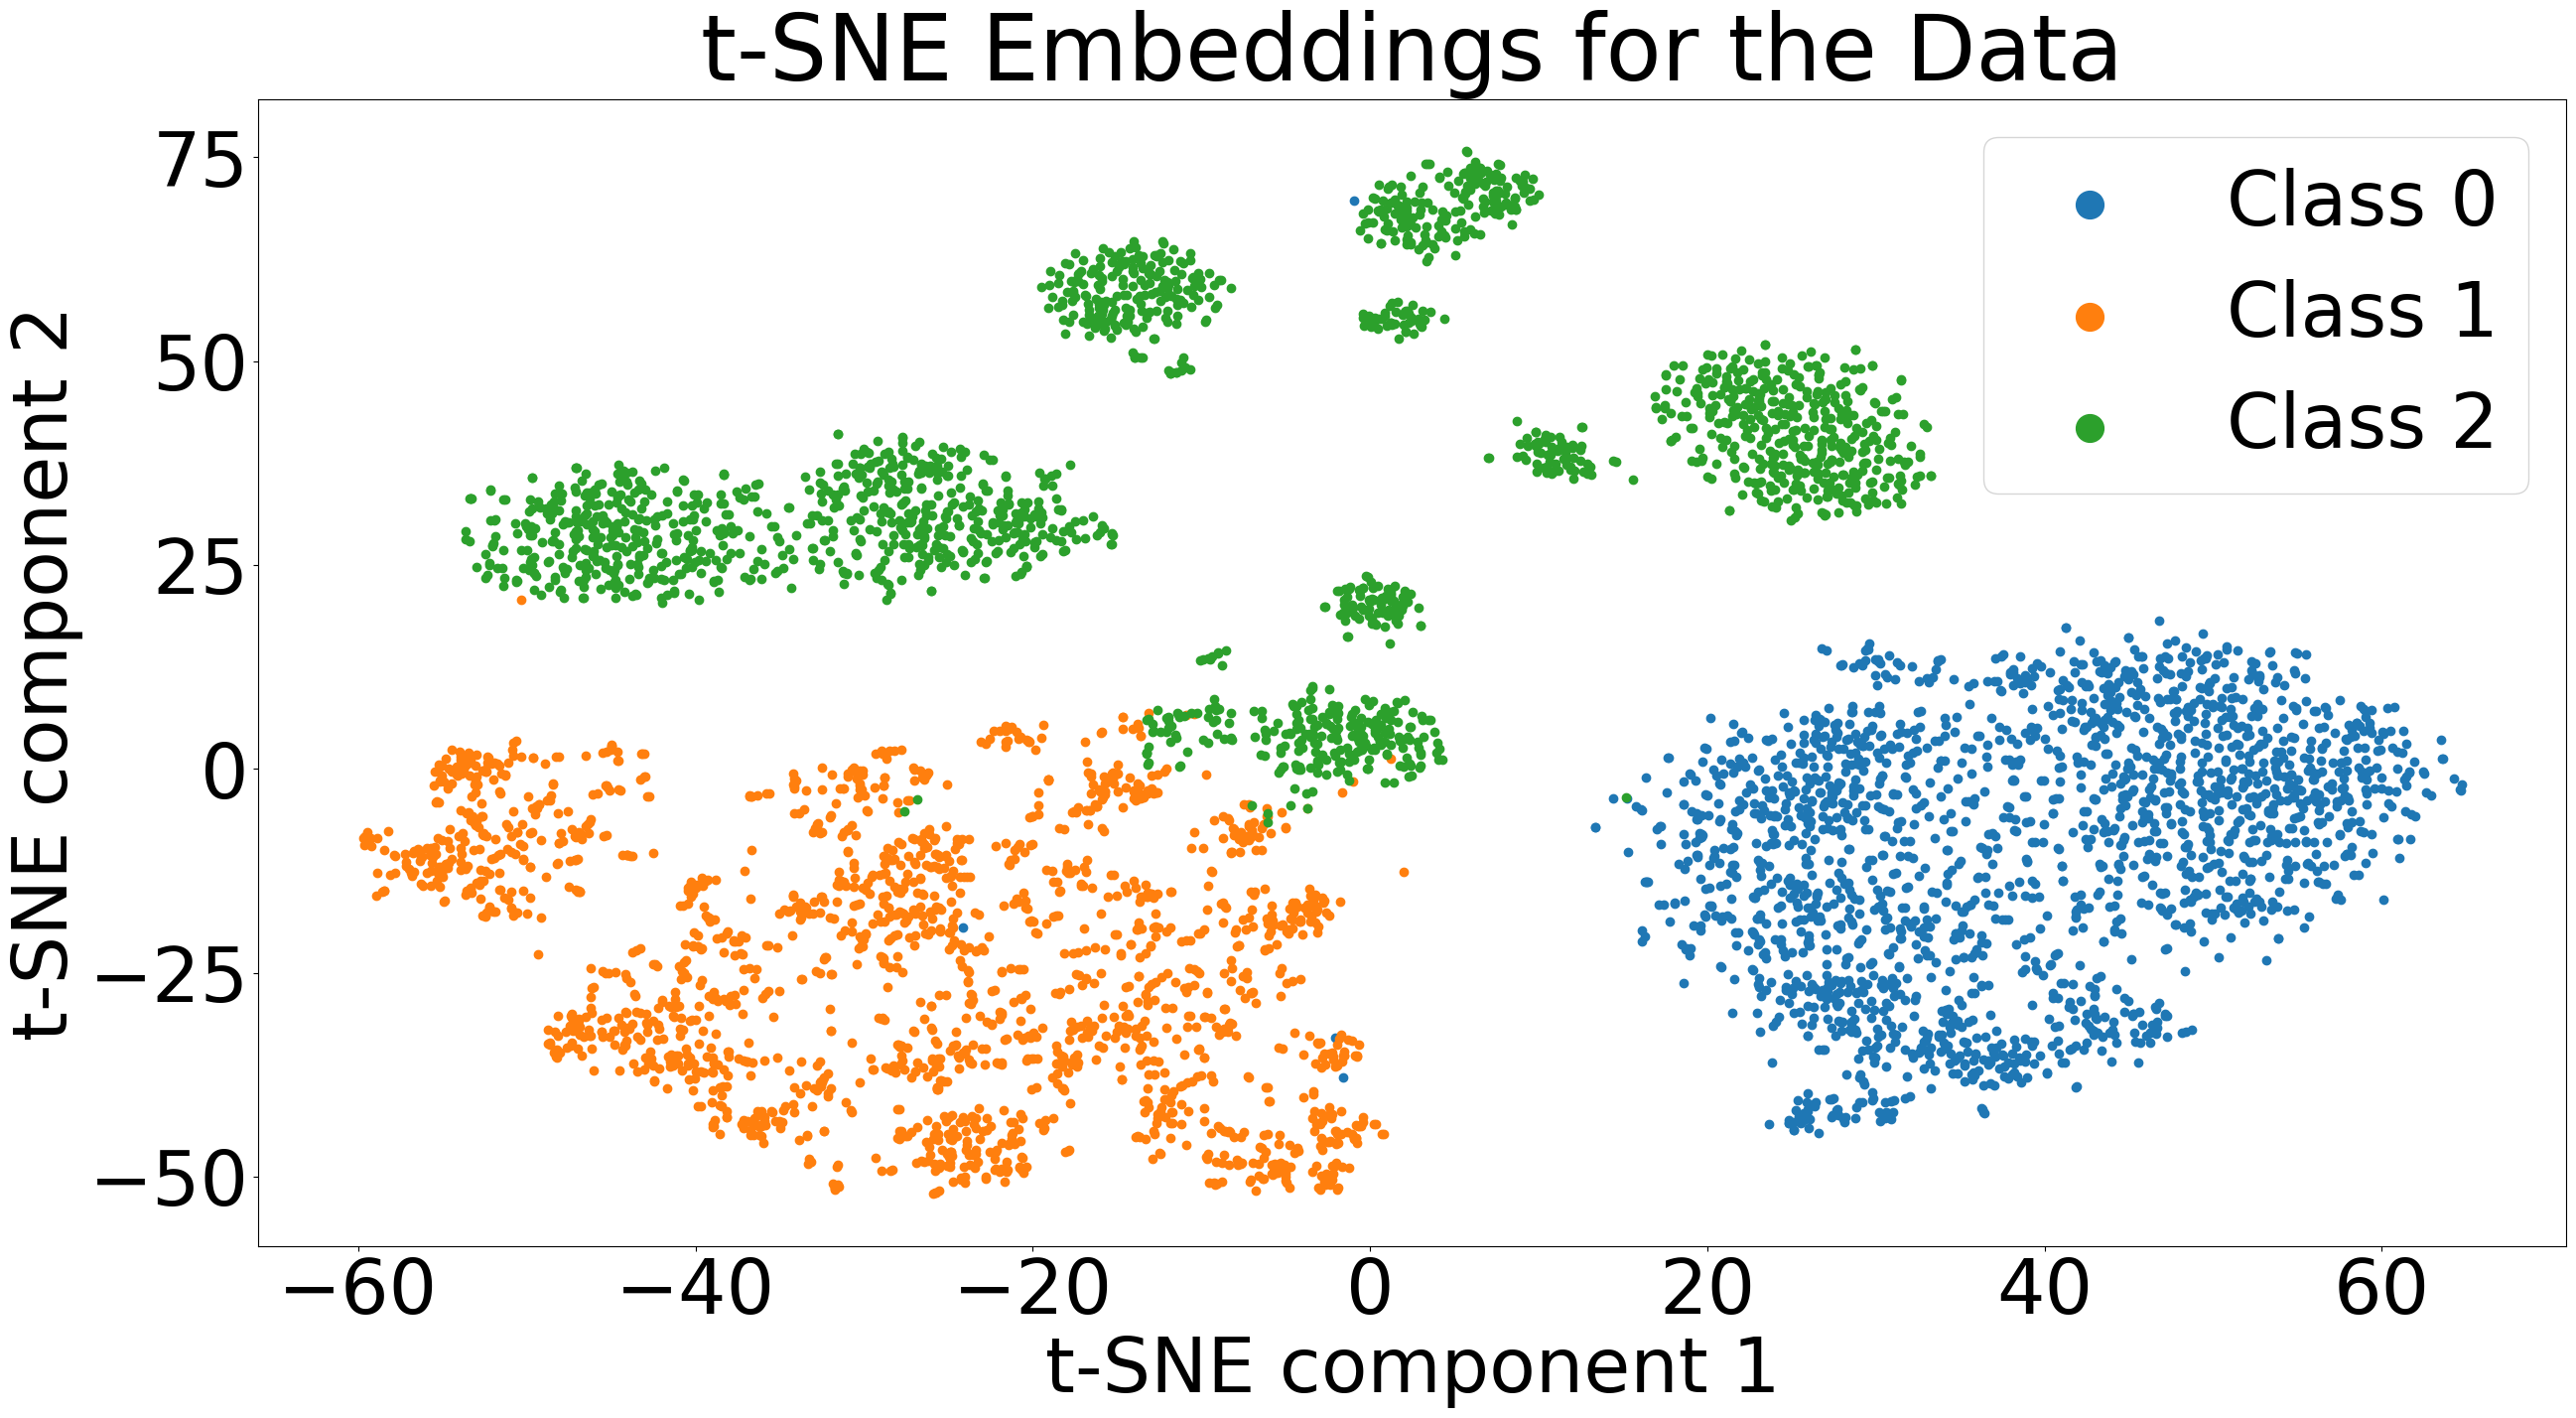

In [20]:
tSNE_plot(model2, test_loader)

In [25]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
from sklearn.manifold import TSNE
import csv
from tqdm import tqdm

# **Make Custom Dataset Using Feature Extraction For Model 1 for Prostrate Cancer Dataset**

In [22]:
# Define the transformations
TempTransformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.554, 0.450, 0.343],[0.231, 0.241, 0.241]),
])

# Function to extract features using the model
def extract_features(image_path, model, device):
    image = Image.open(image_path)
    with torch.no_grad():
        features = model(TempTransformer(image).unsqueeze(0).to(device))
    image.close()
    return features.cpu().numpy().flatten()

In [27]:

# Define the images
#labels_map = read_label(pcancer_subDirectories)
images = []
enu = range(len(pcancer_subDirectories))
labels_map={}
for enu,subDirectory in enumerate(pcancer_subDirectories):
    labels_map.update({enu:subDirectory})
for j in pcancer_subDirectories:
    for i in os.listdir(pcancer_path+'/'+j):
        images.append(pcancer_path+'/'+j+'/'+i)


#model1 = torch.nn.Sequential(*(list(model1.children())[:-1]))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = model1.to(device).eval()

# Extract features for each image
all_features = []
for i, image_path in enumerate(tqdm(images)):
    features = extract_features(image_path, model1, device)
    all_features.append(features)

# Convert the features to a DataFrame
columns = [f"feature_{i}" for i in range(len(all_features[0]))]
df = pd.DataFrame(all_features, columns=columns)

# Save the features to a CSV file
df.to_csv(output_path+"/extracted_features_pm1.csv", index=False)
print("Features saved to 'extracted_features_pm1.csv'.")


100%|██████████| 6000/6000 [01:07<00:00, 89.52it/s]


Features saved to 'extracted_features_pm1.csv'.


In [28]:
df.head(5)

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   1.302789   0.712322   2.082744   0.508969   0.193996   0.622388   
1   1.324936   0.902418   2.222762   0.431222   0.238727   0.572424   
2   0.668692   0.387243   1.256721   0.652896   0.566998   0.578372   
3   0.206550   0.091169   0.488583   0.343926   1.206846   0.394757   
4   0.872982   0.713583   1.238066   0.725550   0.603905   0.961414   

   feature_6  feature_7  feature_8  feature_9  ...  feature_502  feature_503  \
0   1.768005   1.130080   0.476544   0.455878  ...     0.383778     0.711493   
1   1.464264   0.967989   0.466810   0.572990  ...     0.258418     0.480356   
2   1.304378   1.389033   0.427057   0.646793  ...     0.924440     0.576368   
3   0.420187   1.315204   0.553607   1.045663  ...     1.027096     0.874886   
4   1.490732   1.528743   0.396268   0.753431  ...     0.911776     0.854500   

   feature_504  feature_505  feature_506  feature_507  feature_508  \
0     1.381966     0.214938     1.675935     0.218314     0.582839   
1     1.672670     0.242653     1.604286     0.338647     0.531246   
2     1.027658     0.105586     1.326909     0.198466     0.634617   
3     1.140701     0.287392     1.401633     0.255360     0.445555   
4     0.778775     0.125717     1.306134     0.314245     0.621412   

   feature_509  feature_510  feature_511  
0     0.958270     0.893002     0.070155  
1     1.283823     0.520527     0.223469  
2     0.365066     1.164185     0.123130  
3     0.921476     0.619076     0.321910  
4     0.280388     1.098712     0.133650  

[5 rows x 512 columns]

In [29]:
with open(output_path+"/extracted_features_pm1.csv") as fpi, open(output_path+"/final_features_pm1.csv", 'w') as fpo:
    reader = csv.reader(fpi)
    writer = csv.writer(fpo)

    #optionaly handle csv header
    headers = next(reader)
    headers.append('labels')
    writer.writerow(headers)

    for index, row in enumerate(tqdm(reader)):
        if(index>=0 and index<=1999):
            row.append(0)
        elif(index>=2000 and index<=3999):
            row.append(1)
        else:
            row.append(2)
        writer.writerow(row)

6000it [00:02, 2937.33it/s]


# ** Random Forest Implementation **

In [30]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

Accuarcy of Random Forest for classification is 91.25%
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       385
         1.0       0.86      0.88      0.87       393
         2.0       0.90      0.88      0.89       422

    accuracy                           0.91      1200
   macro avg       0.91      0.91      0.91      1200
weighted avg       0.91      0.91      0.91      1200



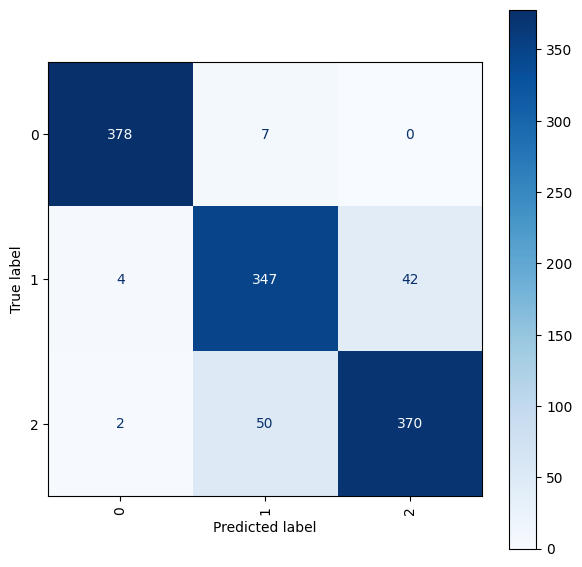

In [32]:
# importing necessary libraries
# loading the dataset
data =  pd.read_csv(output_path+"/final_features_pm1.csv", skiprows = 1).to_numpy()
X = data[:,:-1]

y = data[:,-1]
# X -> features, y -> label
  
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state = 0)


param_dist = {'n_estimators': [200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500],      #randint(50,500)
              'max_depth': [None, 3, 5, 7, 10, 12, 15, 18, 20 ],           #randint(1,20)
              'min_samples_split': [2, 5, 7, 10],
              'min_samples_leaf': [1, 2, 4]
            }      

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
brf = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
brf.fit(X_train, y_train)

rf_predictions = brf.predict(X_test)
  
# model accuracy for X_test  
accuracy = brf.score(X_test, y_test)
print(f'Accuarcy of Random Forest for classification is {accuracy * 100}%') 

# creating a confusion matrix
cmReturned = confusion_matrix(y_test, rf_predictions)
print(classification_report(y_test, rf_predictions))
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay(cmReturned).plot(ax=ax,cmap='Blues', xticks_rotation='vertical', values_format='d')
plt.show()

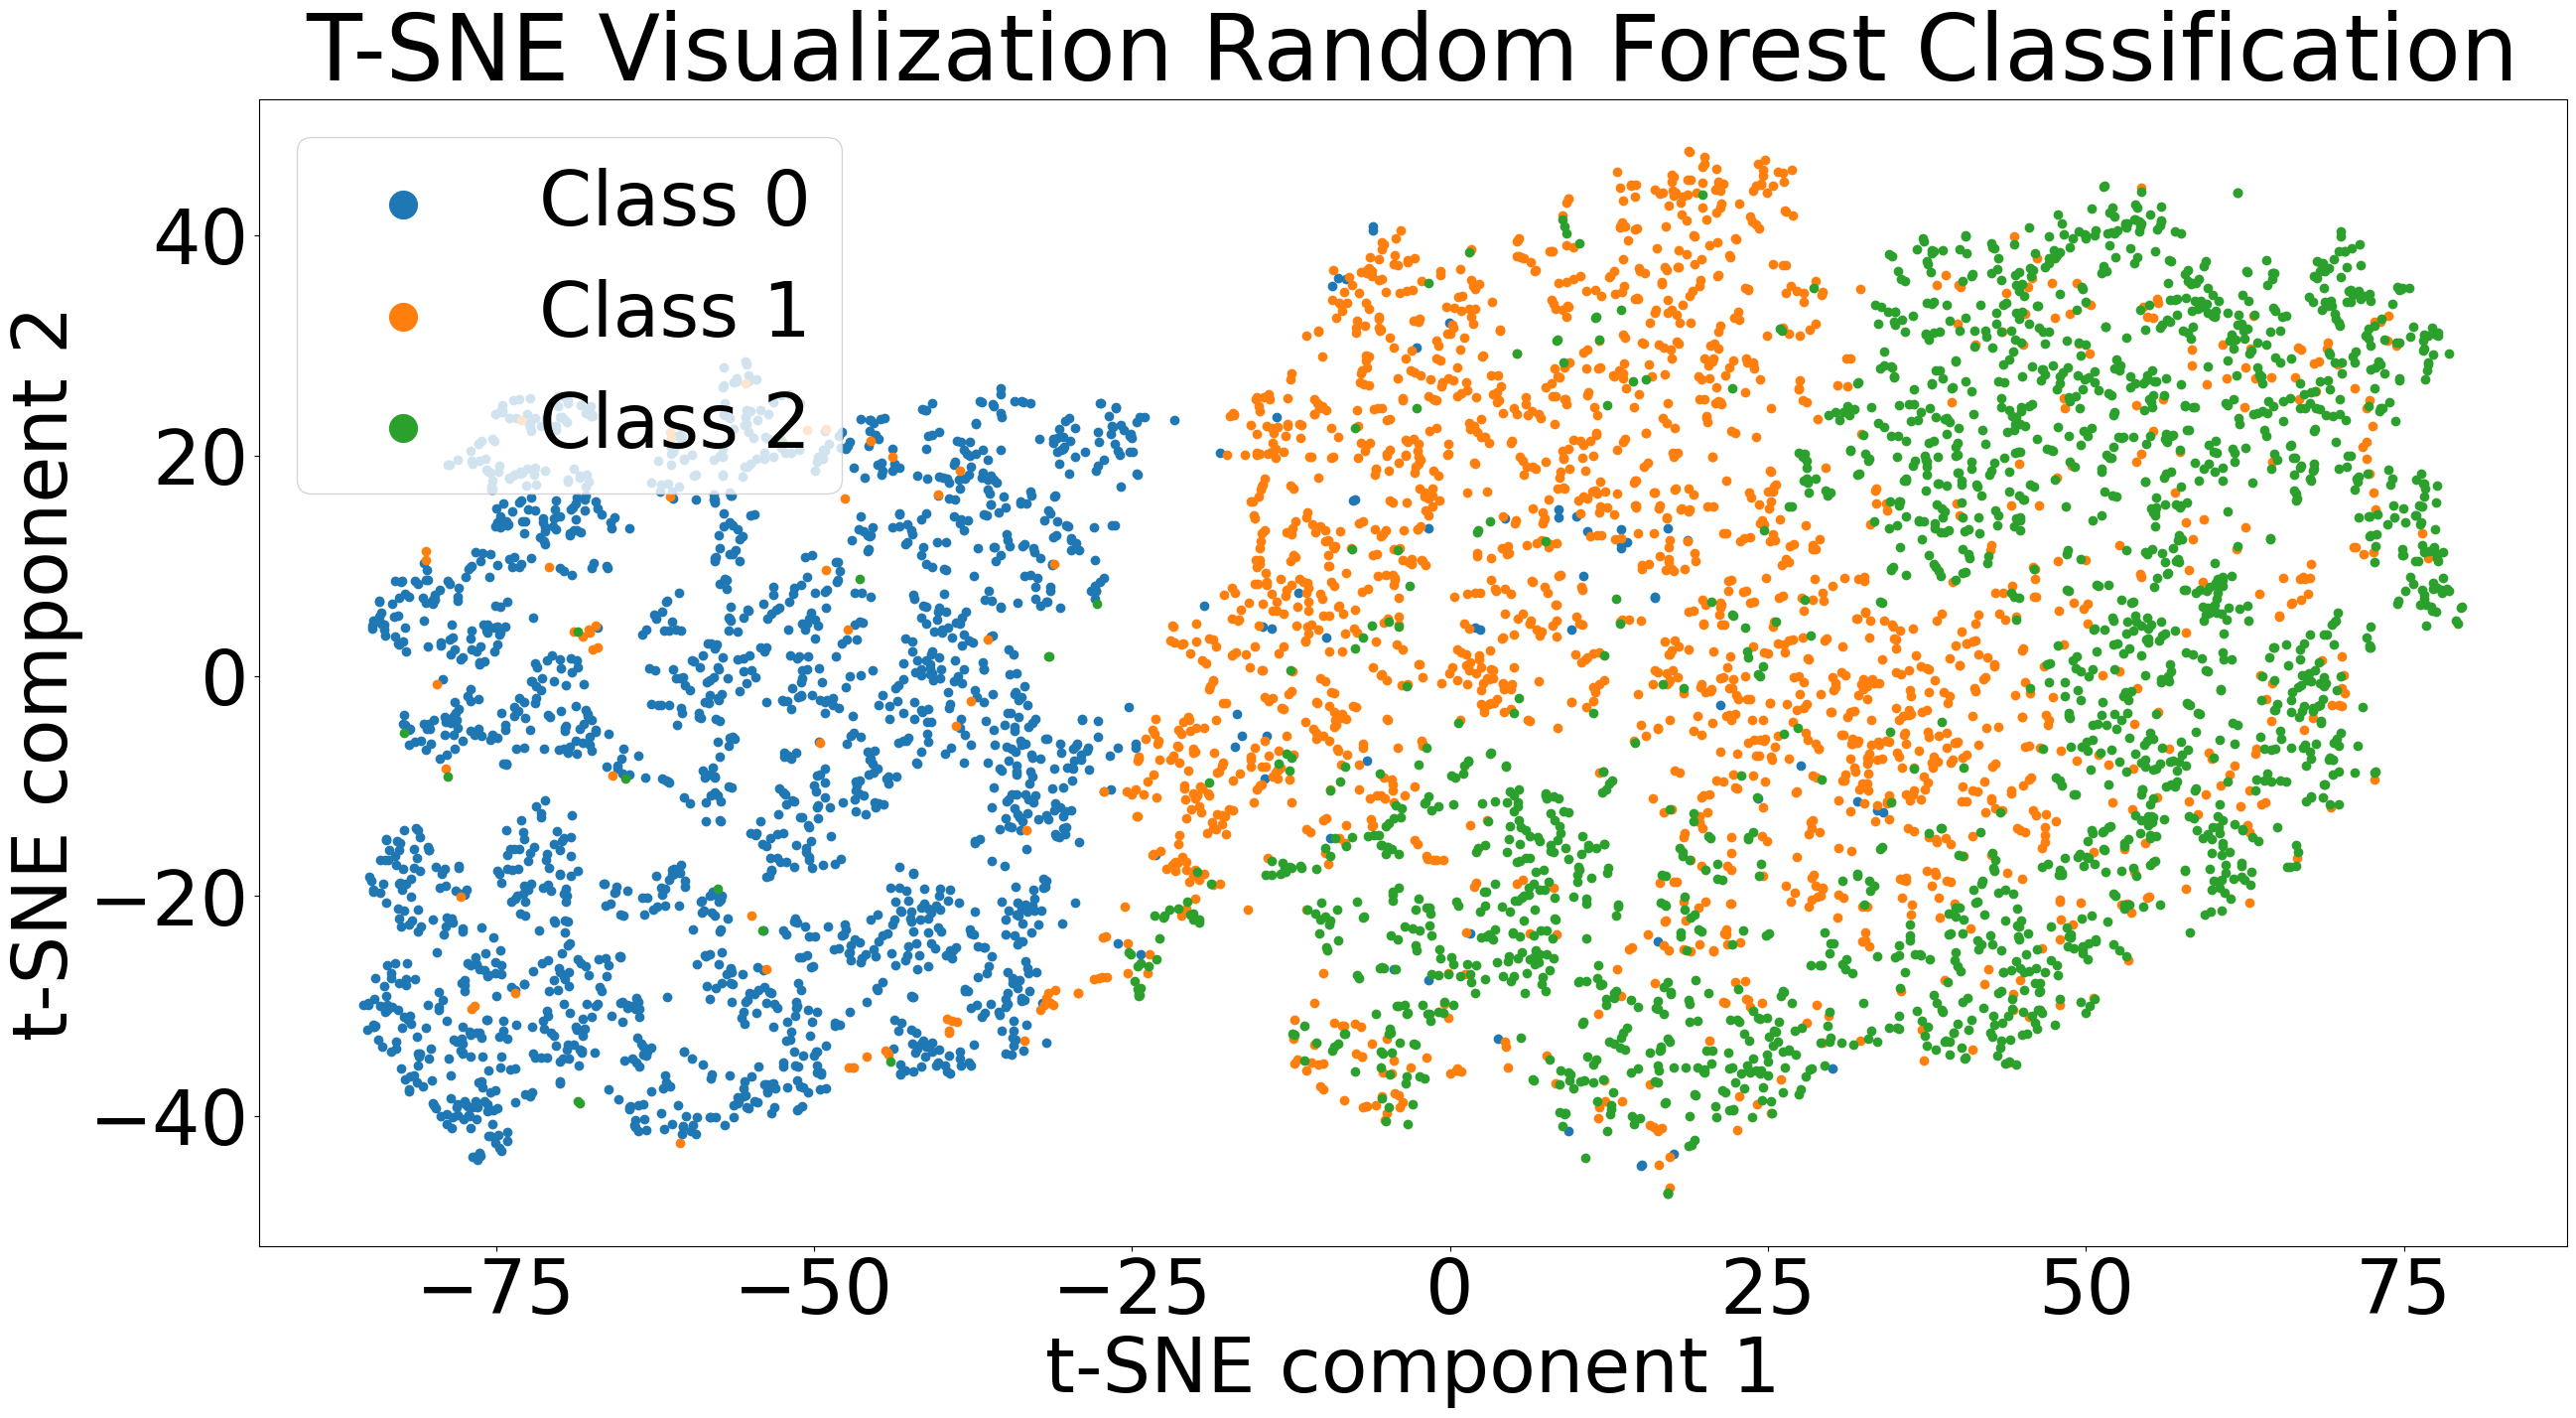

In [33]:
#Make a scatter plot with X_embedded
#TODO: Define the TSNE and transform your data into a 2D embedding space
plt.rcParams.update({'font.size': 55})
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)
plt.figure(figsize=(30, 15))
classes=list(set(y))
#plt.figure()

for cl in classes:
    indices = np.where(y==cl)[0]
    plt.title('T-SNE Visualization Random Forest Classification')
    plt.scatter(X_embedded[indices,0], X_embedded[indices, 1], label=f'Class {int(cl)}')
    plt.ylabel('t-SNE component 2')
    plt.xlabel('t-SNE component 1')

legend = plt.legend()
for handle in legend.legend_handles:
        handle.set_sizes([400])
plt.rcParams.update({'font.size': 10})

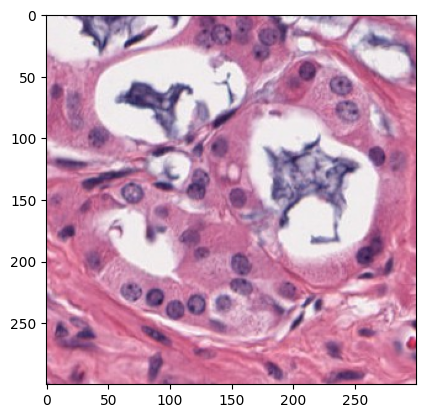

In [34]:
image = Image.open(str(plot_img_path))
plt.imshow(image)

In [35]:
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model1.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 17
conv_layers


In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model1.to(device)
image = TempTransformer(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])
17
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])


In [37]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


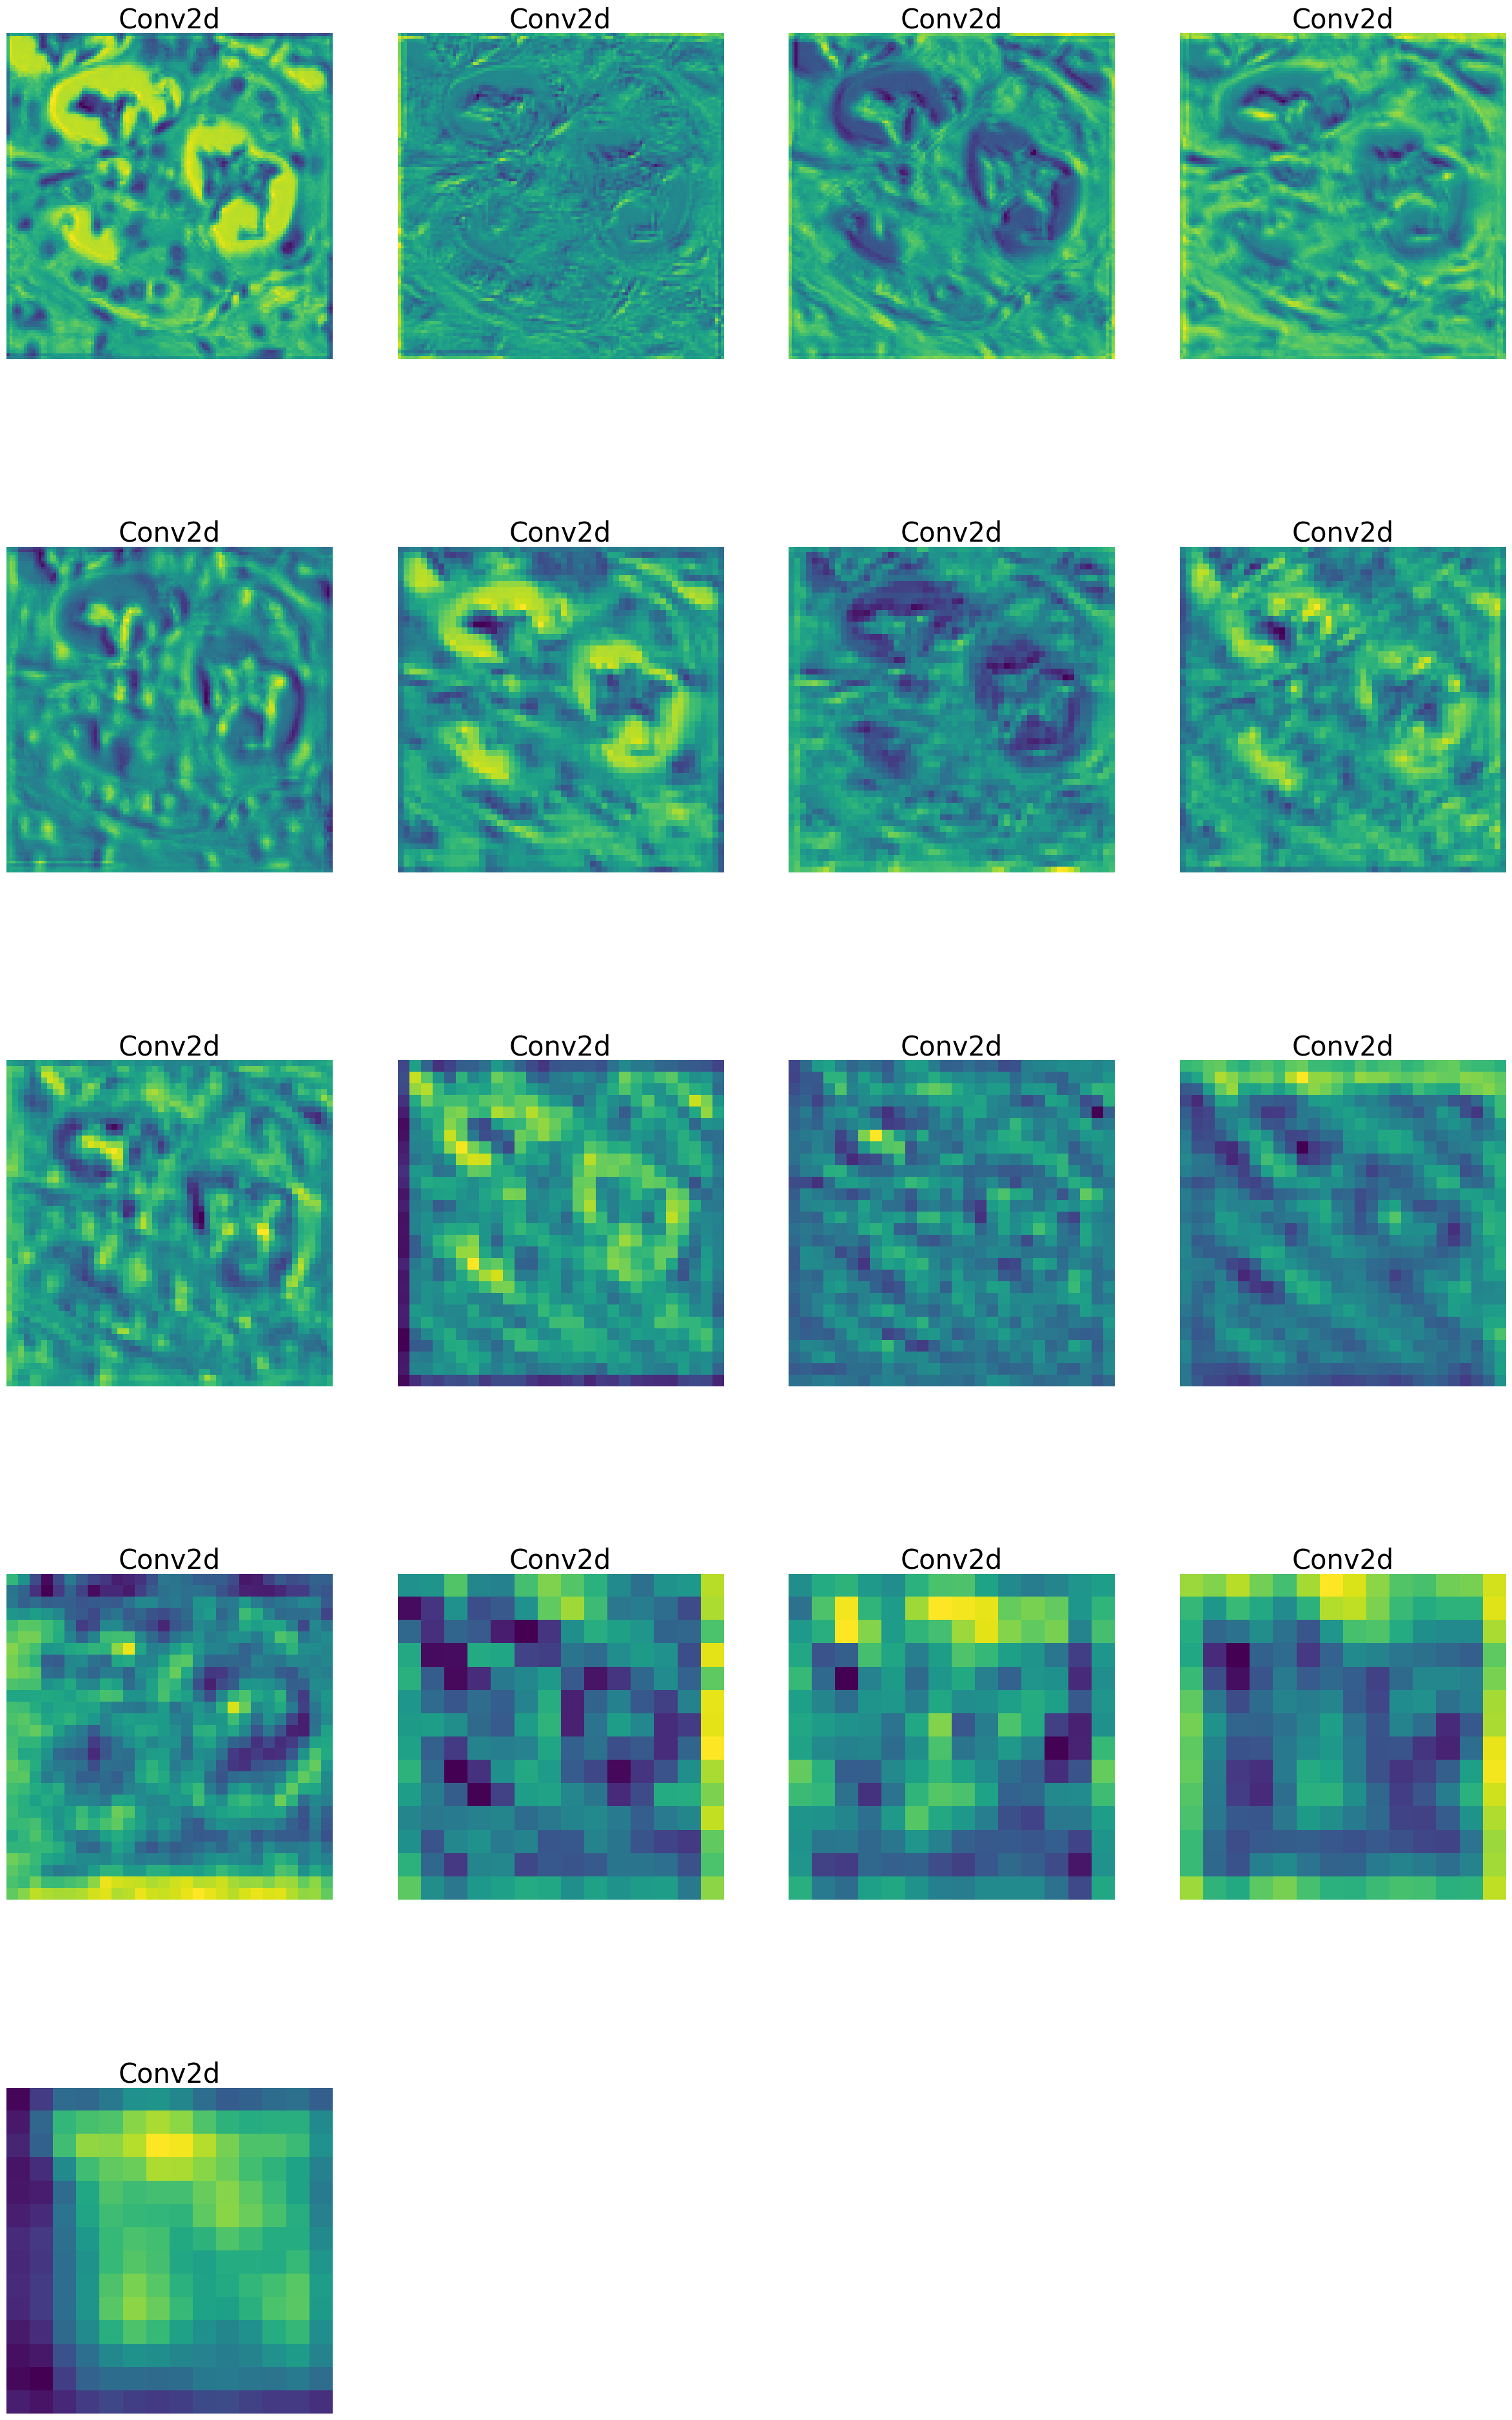

In [38]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str(output_path+'/feature_maps_pm1.jpg'), bbox_inches='tight')

# **Make Custom Dataset Using Feature Extraction For Model 2 for Prostrate Cancer Dataset**

In [39]:
# Define the images
labels_map = read_label(pcancer_subDirectories)
images = []
enu = range(len(pcancer_subDirectories))
labels_map={}
for enu,subDirectory in enumerate(pcancer_subDirectories):
    labels_map.update({enu:subDirectory})
for j in pcancer_subDirectories:
    for i in os.listdir(pcancer_path+'/'+j):
        images.append(pcancer_path+'/'+j+'/'+i)


#model2 = torch.nn.Sequential(*(list(model2.children())[:-1]))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device).eval()

# Extract features for each image
all_features = []
for i, image_path in enumerate(tqdm(images)):
    features = extract_features(image_path, model2, device)
    all_features.append(features)

# Convert the features to a DataFrame
columns = [f"feature_{i}" for i in range(len(all_features[0]))]
df = pd.DataFrame(all_features, columns=columns)

# Save the features to a CSV file
df.to_csv(output_path+"/extracted_features_pm2.csv", index=False)
print("Features saved to 'extracted_features_pm2.csv'.")


['tumor', 'gland', 'nongland']
{0: 'tumor', 1: 'gland', 2: 'nongland'}
The number of labels in the dataset = 3
The 'cuda' device is being used to process the dataset


100%|██████████| 6000/6000 [01:05<00:00, 90.96it/s]


Features saved to 'extracted_features_pm2.csv'.


In [40]:
df.head(5)

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   1.056278   0.285347   0.241389   2.184926   1.350733   0.467459   
1   2.220744   0.357749   0.144775   1.732796   0.287979   0.246533   
2   1.466252   1.533563   0.416264   0.706412   1.214815   0.392577   
3   1.681727   1.491002   0.861922   0.393955   0.694944   0.738616   
4   2.163372   0.455781   0.235145   1.773287   1.196149   0.277736   

   feature_6  feature_7  feature_8  feature_9  ...  feature_502  feature_503  \
0   0.406798   0.784882   1.357196   1.449515  ...     0.337853     0.194383   
1   0.404965   0.224544   3.256739   0.381580  ...     0.210005     0.035458   
2   0.058274   0.561881   1.290468   1.664161  ...     2.524906     0.542850   
3   0.415801   0.255748   2.712666   1.067589  ...     0.801763     0.796944   
4   0.691293   0.030092   1.687550   1.731979  ...     0.851364     0.712318   

   feature_504  feature_505  feature_506  feature_507  feature_508  \
0     1.090559     1.628148     0.182282     0.281283     0.568652   
1     1.754227     0.741560     0.373660     0.751723     0.972457   
2     0.161008     0.678167     0.107899     0.687868     1.121371   
3     0.788588     1.187587     0.327858     0.837005     2.241040   
4     0.079384     0.959870     0.086031     0.454255     1.626499   

   feature_509  feature_510  feature_511  
0     2.218522     0.035615     0.106907  
1     1.672115     0.145867     0.165149  
2     0.954102     0.003335     0.046140  
3     0.425999     0.902391     0.124063  
4     0.415609     0.210516     0.701032  

[5 rows x 512 columns]

In [41]:
with open(output_path+"/extracted_features_pm2.csv") as fpi, open(output_path+"/final_features_pm2.csv", 'w') as fpo:

    reader = csv.reader(fpi)
    writer = csv.writer(fpo)

    #optionaly handle csv header
    headers = next(reader)
    headers.append('labels')
    writer.writerow(headers)

    for index, row in enumerate(tqdm(reader)):
        if(index>=0 and index<=1999):
            row.append(0)
        elif(index>=2000 and index<=3999):
            row.append(1)
        else:
            row.append(2)
        writer.writerow(row)

6000it [00:02, 2999.21it/s]


# ** Random Forest Implementation for model 2**

Accuarcy of Random Forest for classification is 92.75%
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       385
         1.0       0.85      0.94      0.89       393
         2.0       0.96      0.89      0.92       422

    accuracy                           0.93      1200
   macro avg       0.93      0.93      0.93      1200
weighted avg       0.93      0.93      0.93      1200



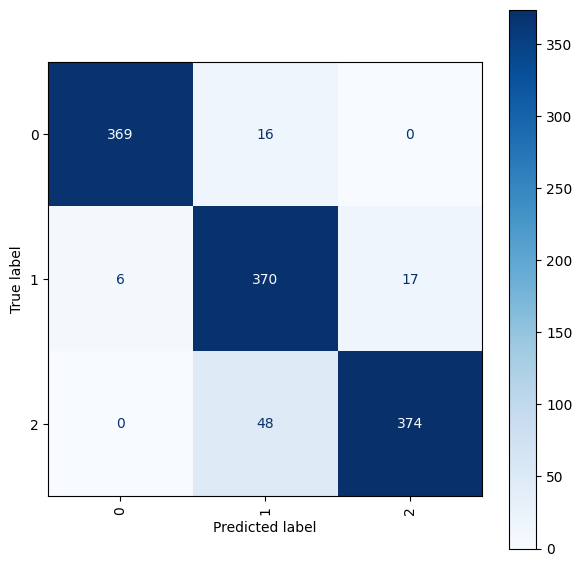

In [42]:
# importing necessary libraries
# loading the dataset
data =  pd.read_csv(output_path+"/final_features_pm2.csv", skiprows = 1).to_numpy()
X = data[:,:-1]

y = data[:,-1]
# X -> features, y -> label
  
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state = 0)

param_dist = {'n_estimators': [200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500],      #randint(50,500)
              'max_depth': [None, 3, 5, 7, 10, 12, 15, 18, 20 ],           #randint(1,20)
              'min_samples_split': [2, 5, 7, 10],
              'min_samples_leaf': [1, 2, 4]
            }

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
brf = RandomizedSearchCV(rf, param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
brf.fit(X_train, y_train)

rf_predictions = brf.predict(X_test)
  
# model accuracy for X_test  
accuracy = brf.score(X_test, y_test)
print(f'Accuarcy of Random Forest for classification is {accuracy * 100}%') 

# creating a confusion matrix
cmReturned = confusion_matrix(y_test, rf_predictions)
print(classification_report(y_test, rf_predictions))
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay(cmReturned).plot(ax=ax,cmap='Blues', xticks_rotation='vertical', values_format='d')
plt.show()

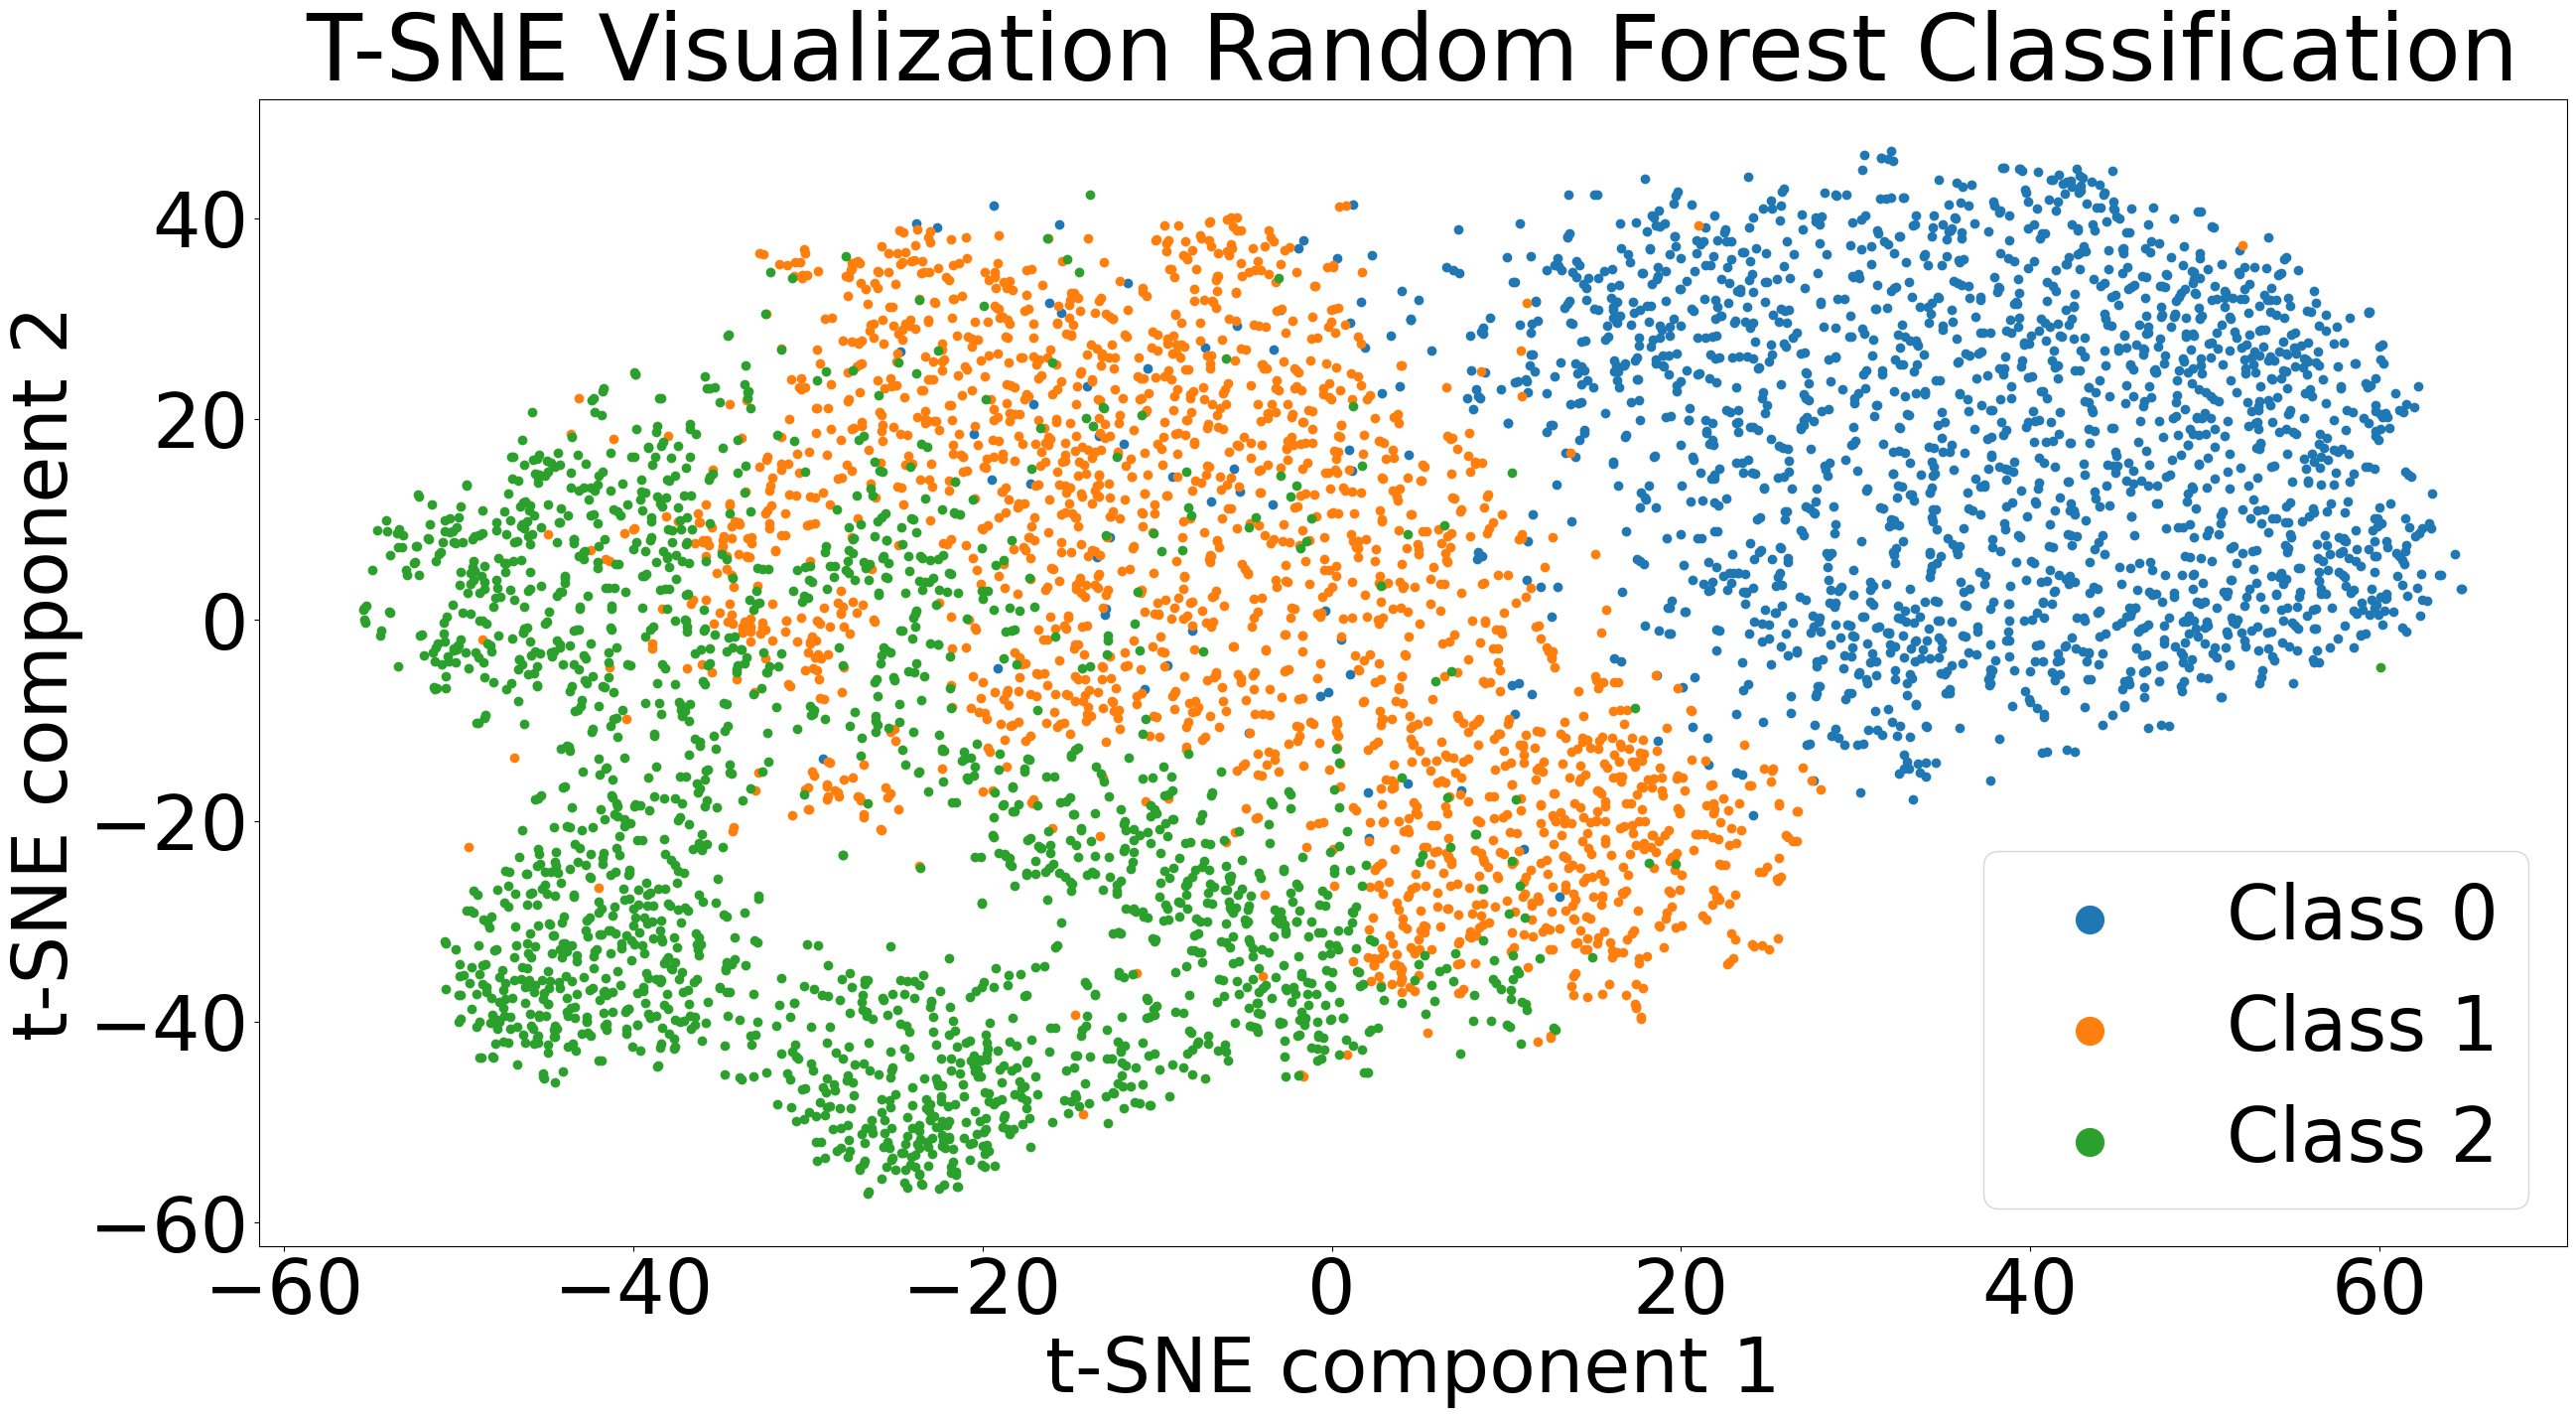

In [43]:
#Make a scatter plot with X_embedded
#TODO: Define the TSNE and transform your data into a 2D embedding space
plt.rcParams.update({'font.size': 55})
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

classes=list(set(y))
plt.figure(figsize=(30, 15))

for cl in classes:
    indices = np.where(y==cl)[0]
    plt.title('T-SNE Visualization Random Forest Classification')
    plt.scatter(X_embedded[indices,0], X_embedded[indices, 1], label=f'Class {int(cl)}')
    plt.ylabel('t-SNE component 2')
    plt.xlabel('t-SNE component 1')

legend = plt.legend()
for handle in legend.legend_handles:
        handle.set_sizes([400])
plt.rcParams.update({'font.size': 10})

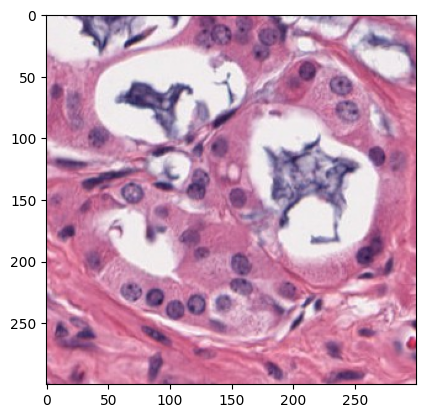

In [44]:
image = Image.open(str(plot_img_path))
plt.imshow(image)

In [45]:
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model2.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 17
conv_layers


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model2.to(device)
image = TempTransformer(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)
    
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])
17
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


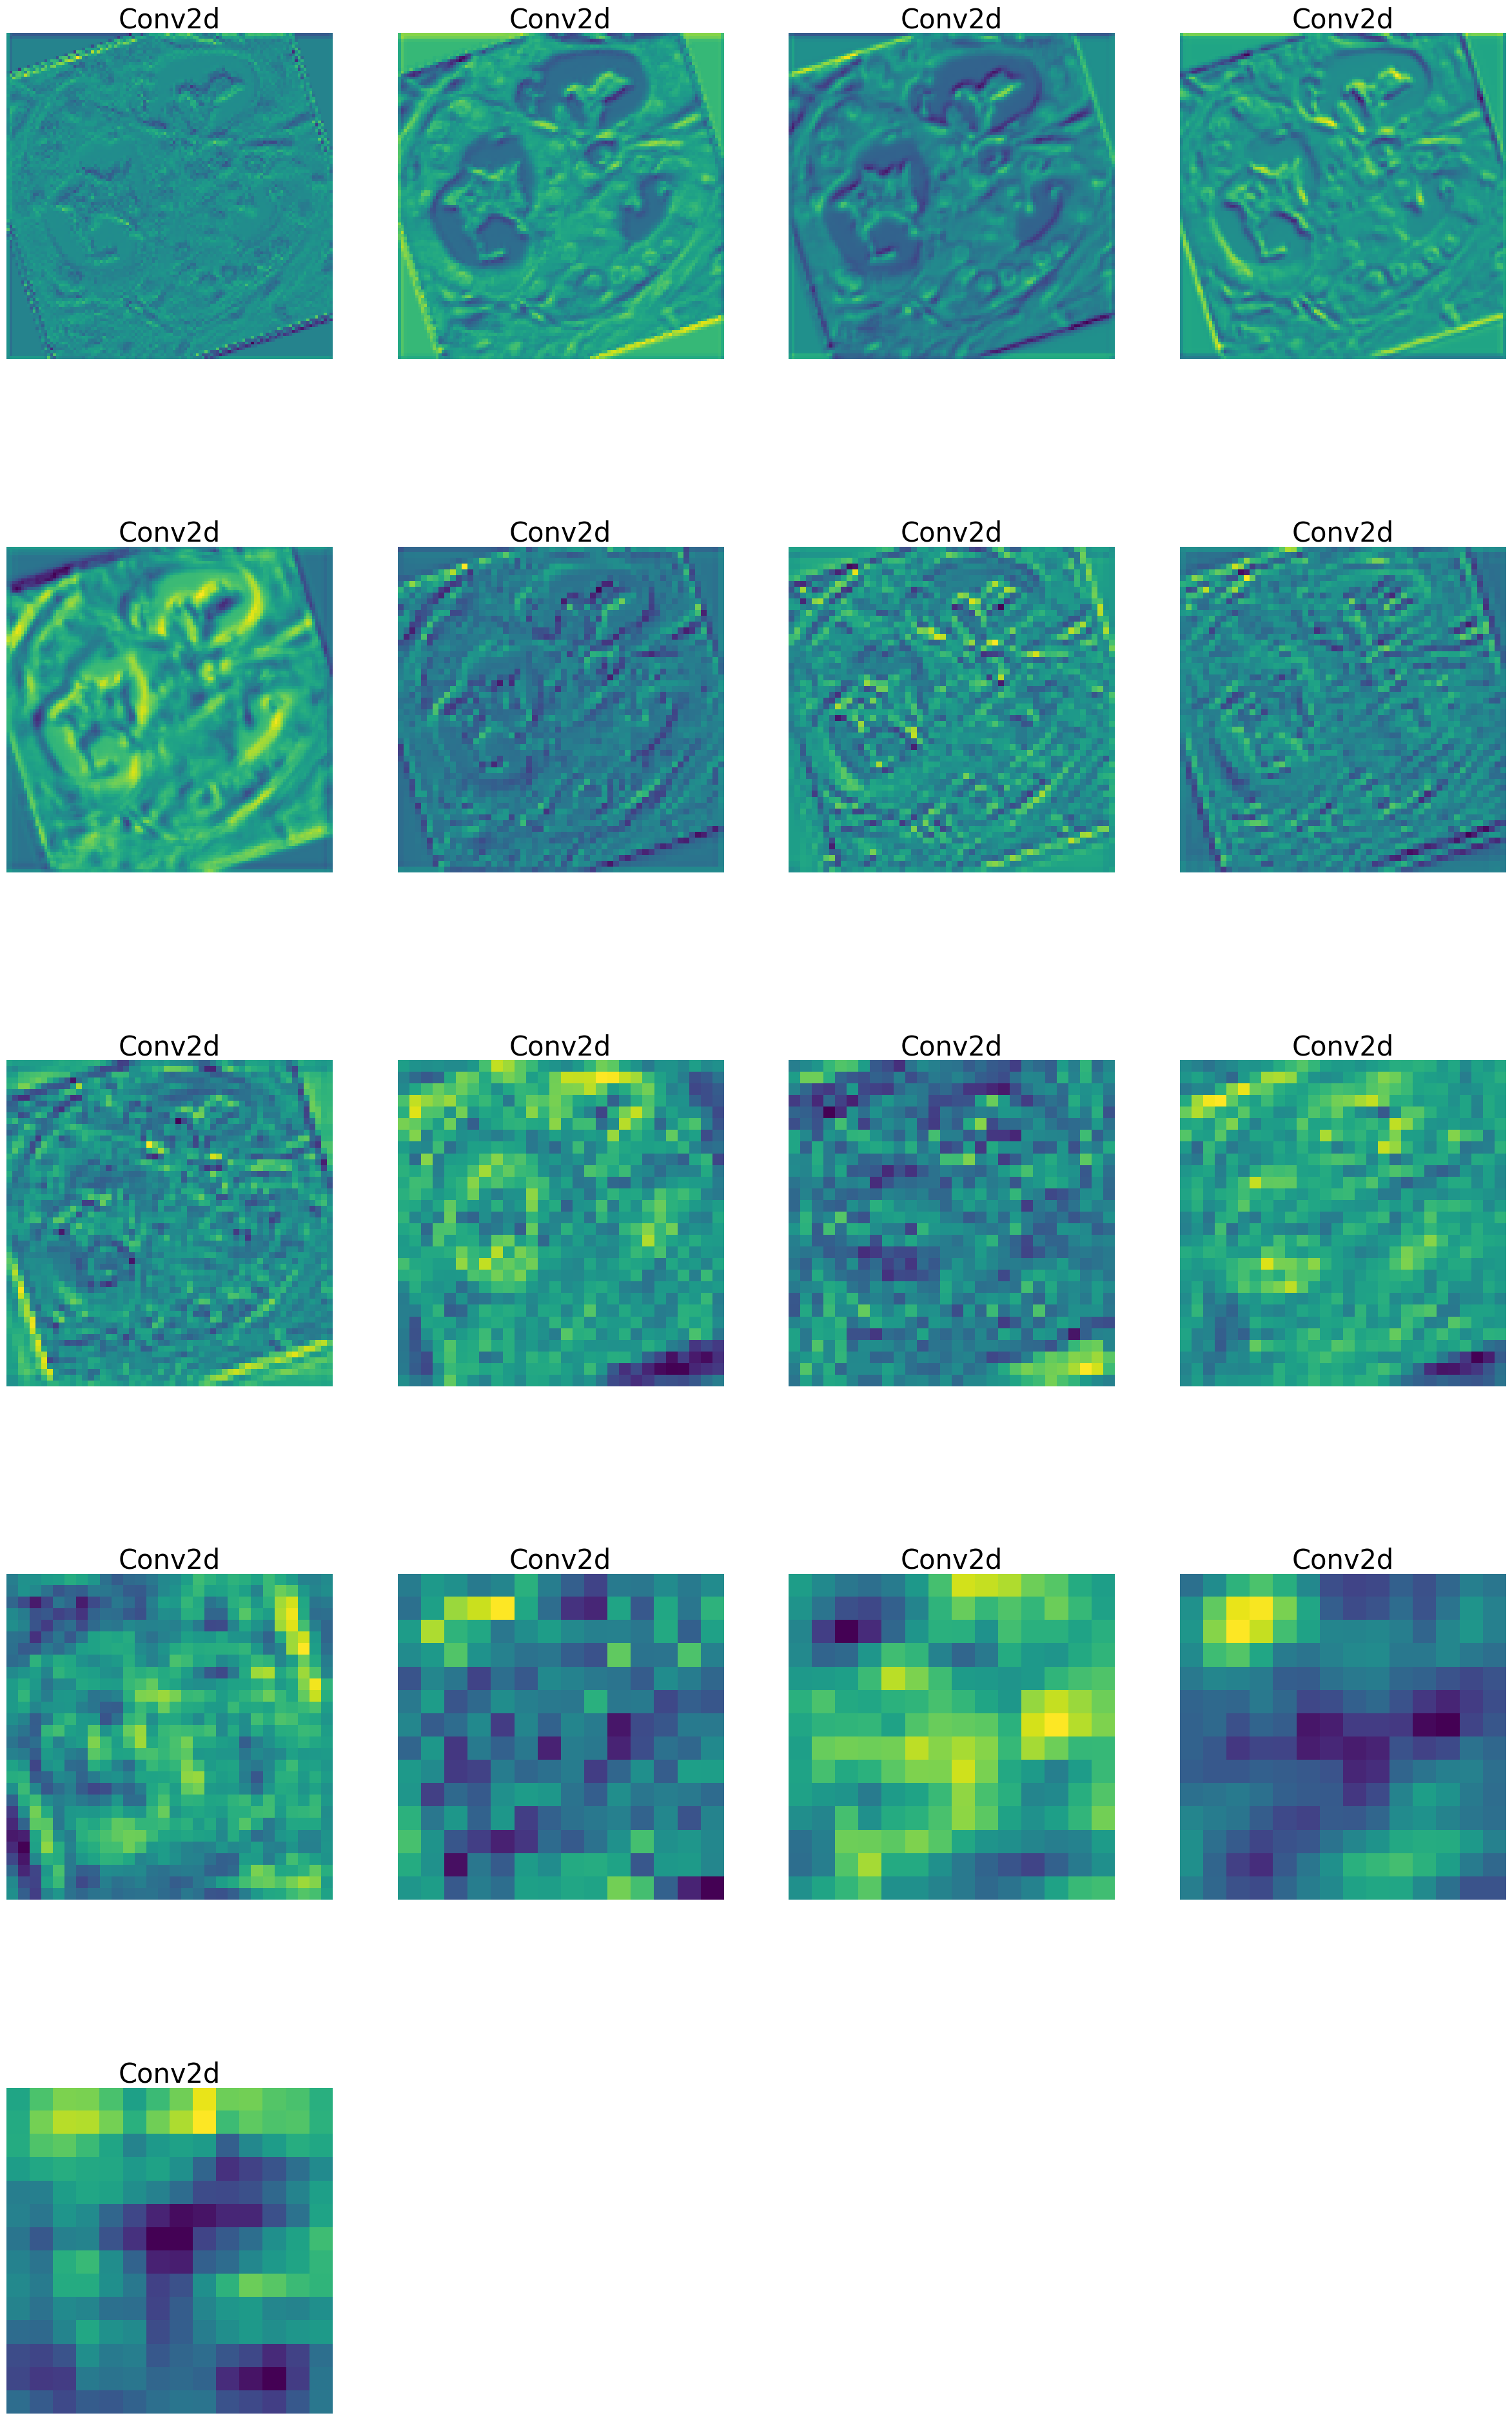

In [47]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str(output_path+'/feature_maps_pm2.jpg'), bbox_inches='tight')

# **Make Custom Dataset Using Feature Extraction For Model 1 for Animal Faces Dataset**

In [48]:
model1 = torch.load(model1_path)
model1 = torch.nn.Sequential(*(list(model1.children())[:-1]))
model1.eval()
#model2 = torch.load('/kaggle/input/models/COMP6321_ResNet_Task1_CancerDataset_Model_Final_TransferLearning0.pth')
model2 = models.resnet18(weights="IMAGENET1K_V1").to(device)
model2.fc = nn.Linear(512,len(afaces_labels_map)).to(device) # fine tuning the last layer
model2 = torch.nn.Sequential(*(list(model2.children())[:-1]))
model2.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [49]:
labels_map = read_label(afaces_subDirectories)
images = []
enu = range(len(afaces_subDirectories))
labels_map={}
for enu,subDirectory in enumerate(afaces_subDirectories):
    labels_map.update({enu:subDirectory})
for j in afaces_subDirectories:
    for i in os.listdir(afaces_path+'/'+j):
        images.append(afaces_path+'/'+j+'/'+i)


#model1 = torch.nn.Sequential(*(list(model1.children())[:-1]))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = model1.to(device).eval()

# Extract features for each image
all_features = []
for i, image_path in enumerate(tqdm(images)):
    features = extract_features(image_path, model1, device)
    all_features.append(features)

# Convert the features to a DataFrame
columns = [f"feature_{i}" for i in range(len(all_features[0]))]
df = pd.DataFrame(all_features, columns=columns)

# Save the features to a CSV file
df.to_csv(output_path+"/extracted_features_am1.csv", index=False)
print("Features saved to 'extracted_features_am1.csv'.")

['dog', 'wild', 'cat']
{0: 'dog', 1: 'wild', 2: 'cat'}
The number of labels in the dataset = 3
The 'cuda' device is being used to process the dataset


100%|██████████| 6000/6000 [01:21<00:00, 73.59it/s]


Features saved to 'extracted_features_am1.csv'.


In [50]:
df.head(5)

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   1.312324   1.504102   2.825182   1.738112   0.277442   2.260203   
1   1.511484   0.800641   2.111753   1.082449   0.285506   1.393641   
2   3.427290   3.117525   4.572476   2.523967   0.022109   3.504925   
3   3.120707   3.698756   3.409109   2.177152   0.075531   3.258620   
4   1.180294   0.873252   0.782714   0.757521   0.159684   0.872364   

   feature_6  feature_7  feature_8  feature_9  ...  feature_502  feature_503  \
0   3.051591   1.336426   0.381880   0.170215  ...     0.426130     1.021829   
1   2.678997   1.829189   0.275080   0.333859  ...     0.164757     0.915366   
2   5.120661   1.490662   0.467642   0.000000  ...     0.029793     0.737767   
3   3.280836   1.143163   0.381564   0.243921  ...     0.651179     0.994701   
4   1.097668   1.226543   0.470002   0.224533  ...     0.605591     0.773978   

   feature_504  feature_505  feature_506  feature_507  feature_508  \
0     0.409285     0.106900     1.199832     0.194327     1.247335   
1     0.845805     0.213586     0.687667     0.427011     0.973751   
2     0.827530     0.083356     0.860980     0.268616     1.701743   
3     0.219895     0.075104     1.384346     0.010781     1.326957   
4     0.246668     0.139909     1.144625     0.063169     0.910387   

   feature_509  feature_510  feature_511  
0     0.085811     3.062100     0.002764  
1     0.521979     2.224889     0.064150  
2     0.095335     4.881900     0.000000  
3     0.027139     3.724716     0.015970  
4     0.011099     1.209092     0.034227  

[5 rows x 512 columns]

In [51]:
with open(output_path+"/extracted_features_am1.csv") as fpi, open(output_path+"/final_features_am1.csv", 'w') as fpo:

    reader = csv.reader(fpi)
    writer = csv.writer(fpo)

    #optionaly handle csv header
    headers = next(reader)
    headers.append('labels')
    writer.writerow(headers)

    for index, row in enumerate(tqdm(reader)):
        if(index>=0 and index<=1999):
            row.append(0)
        elif(index>=2000 and index<=3999):
            row.append(1)
        else:
            row.append(2)
        writer.writerow(row)

6000it [00:02, 2925.06it/s]


Accuarcy of Random Forest for classification is 56.41666666666667%
              precision    recall  f1-score   support

         0.0       0.51      0.56      0.53       385
         1.0       0.64      0.68      0.66       393
         2.0       0.54      0.46      0.50       422

    accuracy                           0.56      1200
   macro avg       0.56      0.57      0.56      1200
weighted avg       0.56      0.56      0.56      1200



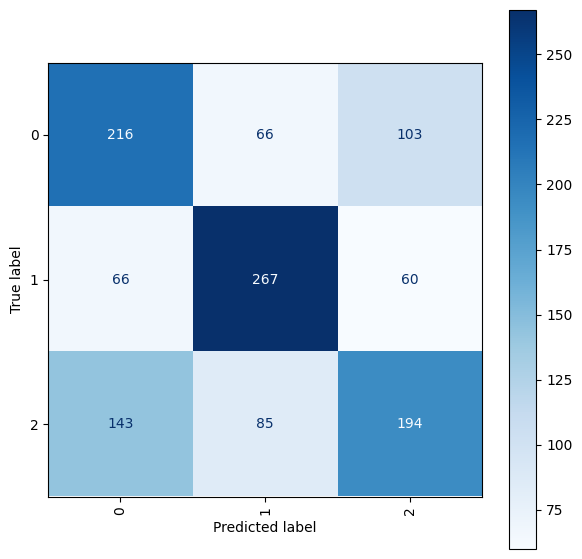

In [52]:
# importing necessary libraries
# loading the dataset
data =  pd.read_csv(output_path+"/final_features_am1.csv", skiprows = 1).to_numpy()
X = data[:,:-1]

y = data[:,-1]
# X -> features, y -> label
  
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state = 0)

param_dist = {'n_estimators': [200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500],      #randint(50,500)
              'max_depth': [None, 3, 5, 7, 10, 12, 15, 18, 20 ],           #randint(1,20)
              'min_samples_split': [2, 5, 7, 10],
              'min_samples_leaf': [1, 2, 4]
            }

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
brf = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
brf.fit(X_train, y_train)

rf_predictions = brf.predict(X_test)
  
# model accuracy for X_test  
accuracy = brf.score(X_test, y_test)
print(f'Accuarcy of Random Forest for classification is {accuracy * 100}%') 

# creating a confusion matrix
cmReturned = confusion_matrix(y_test, rf_predictions)
print(classification_report(y_test, rf_predictions))
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay(cmReturned).plot(ax=ax,cmap='Blues', xticks_rotation='vertical', values_format='d')
plt.show()

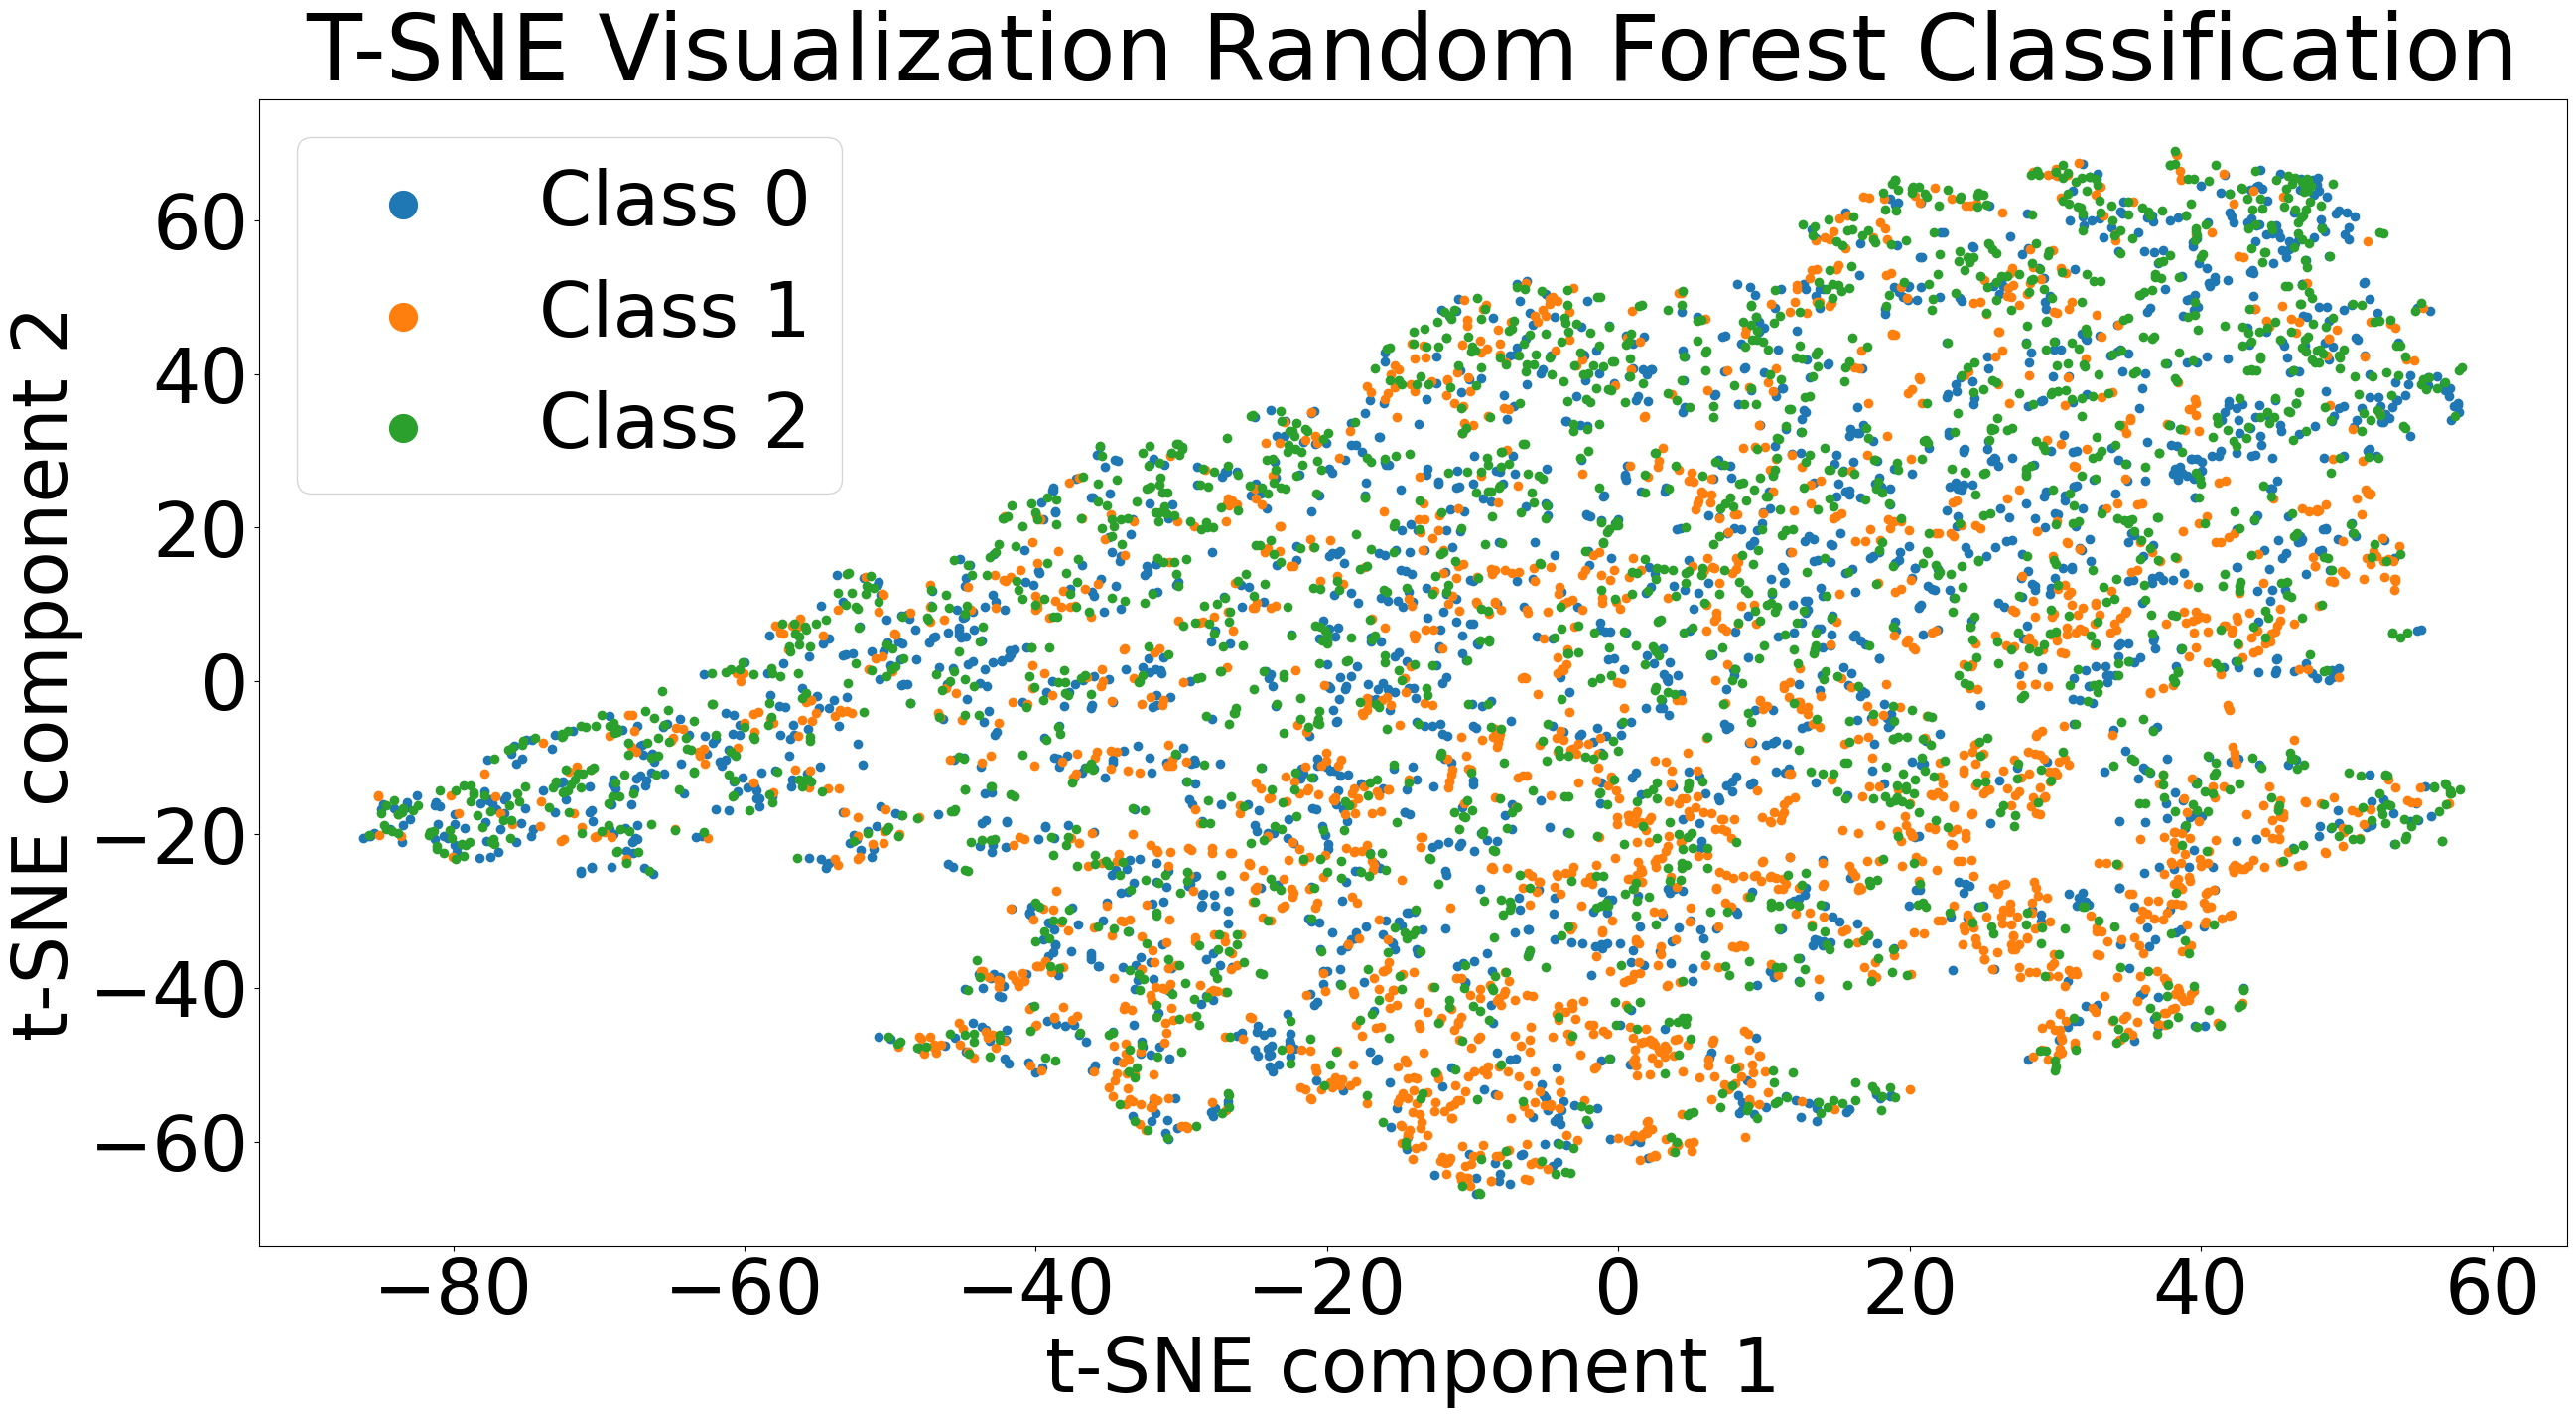

In [53]:
#Make a scatter plot with X_embedded
#TODO: Define the TSNE and transform your data into a 2D embedding space
plt.rcParams.update({'font.size': 55})
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

classes=list(set(y))
plt.figure(figsize=(30, 15))

for cl in classes:
    indices = np.where(y==cl)[0]
    plt.title('T-SNE Visualization Random Forest Classification')
    plt.scatter(X_embedded[indices,0], X_embedded[indices, 1], label=f'Class {int(cl)}')
    plt.ylabel('t-SNE component 2')
    plt.xlabel('t-SNE component 1')
legend = plt.legend()
for handle in legend.legend_handles:
        handle.set_sizes([400])
plt.rcParams.update({'font.size': 10})

# **Make Custom Dataset Using Feature Extraction For Model 2 for Animal Faces Dataset**

In [54]:
labels_map = read_label(afaces_subDirectories)
images = []
enu = range(len(afaces_subDirectories))
labels_map={}
for enu,subDirectory in enumerate(afaces_subDirectories):
    labels_map.update({enu:subDirectory})
for j in afaces_subDirectories:
    for i in os.listdir(afaces_path+'/'+j):
        images.append(afaces_path+'/'+j+'/'+i)


#model2 = torch.nn.Sequential(*(list(model2.children())[:-1]))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device).eval()

# Extract features for each image
all_features = []
for i, image_path in enumerate(tqdm(images)):
    features = extract_features(image_path, model2, device)
    all_features.append(features)

# Convert the features to a DataFrame
columns = [f"feature_{i}" for i in range(len(all_features[0]))]
df = pd.DataFrame(all_features, columns=columns)

# Save the features to a CSV file
df.to_csv(output_path+"/extracted_features_am2.csv", index=False)
print("Features saved to 'extracted_features_am2.csv'.")

['dog', 'wild', 'cat']
{0: 'dog', 1: 'wild', 2: 'cat'}
The number of labels in the dataset = 3
The 'cuda' device is being used to process the dataset


100%|██████████| 6000/6000 [01:19<00:00, 75.50it/s]


Features saved to 'extracted_features_am2.csv'.


In [55]:
df.head(5)

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   5.063563   2.763412   1.118927   1.960885   0.504027   1.905337   
1   3.216697   0.630978   3.021190   2.176475   1.547935   0.011067   
2   4.115427   0.968053   0.724346   1.154245   0.301351   0.065950   
3   3.521708   1.664681   2.069411   0.570592   1.003179   0.842916   
4   1.910437   1.603957   1.206066   0.315027   0.598954   0.406613   

   feature_6  feature_7  feature_8  feature_9  ...  feature_502  feature_503  \
0   0.080329   0.157918   1.205139   0.418332  ...     3.016258     0.548442   
1   0.558673   3.209671   0.899958   1.507893  ...     0.094182     0.300142   
2   0.120375   0.309014   0.466887   0.893262  ...     1.582813     1.424661   
3   1.576949   1.428890   0.148563   3.764371  ...     0.222666     0.744002   
4   1.168959   1.333524   0.825855   3.274848  ...     0.634758     0.961277   

   feature_504  feature_505  feature_506  feature_507  feature_508  \
0     0.997161     1.187304     1.516569     1.535313     1.022017   
1     1.007688     1.094719     0.299154     2.274360     1.102059   
2     0.274156     1.375512     0.720783     0.818424     1.684993   
3     0.050706     2.930175     0.000000     1.242014     2.506237   
4     0.315292     1.359492     0.058554     0.270874     1.108426   

   feature_509  feature_510  feature_511  
0     0.679294     1.571309     0.019535  
1     0.146778     0.803399     0.229230  
2     0.422036     1.010013     0.921694  
3     0.397136     2.406919     0.055096  
4     0.769259     0.828744     0.137505  

[5 rows x 512 columns]

In [56]:
with open(output_path+"/extracted_features_am2.csv") as fpi, open(output_path+"/final_features_am2.csv", 'w') as fpo:

    reader = csv.reader(fpi)
    writer = csv.writer(fpo)

    #optionaly handle csv header
    headers = next(reader)
    headers.append('labels')
    writer.writerow(headers)

    for index, row in enumerate(tqdm(reader)):
        if(index>=0 and index<=1999):
            row.append(0)
        elif(index>=2000 and index<=3999):
            row.append(1)
        else:
            row.append(2)
        writer.writerow(row)

6000it [00:02, 2956.24it/s]


Accuarcy of Random Forest for classification is 99.25%
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       385
         1.0       0.98      0.99      0.99       393
         2.0       1.00      1.00      1.00       422

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



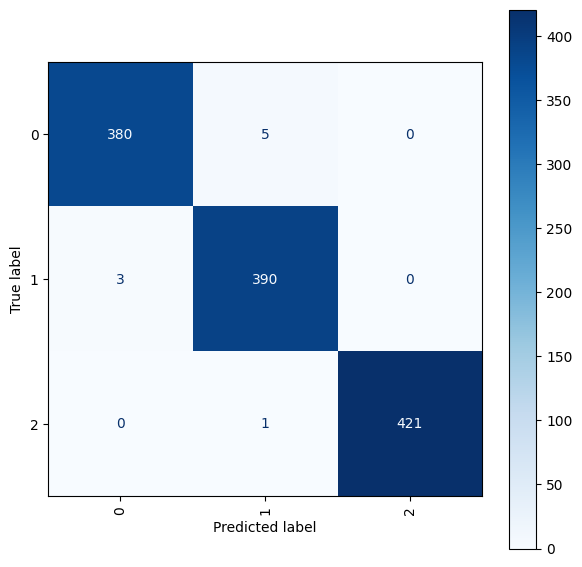

In [57]:
# importing necessary libraries 
# loading the dataset
data =  pd.read_csv(output_path+"/final_features_am2.csv", skiprows = 1).to_numpy()
X = data[:,:-1]

y = data[:,-1]
# X -> features, y -> label
  
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state = 0)

param_dist = {'n_estimators': [200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500],      #randint(50,500)
              'max_depth': [None, 3, 5, 7, 10, 12, 15, 18, 20 ],           #randint(1,20)
              'min_samples_split': [2, 5, 7, 10],
              'min_samples_leaf': [1, 2, 4]
            }

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
brf = RandomizedSearchCV(rf, param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
brf.fit(X_train, y_train)

rf_predictions = brf.predict(X_test)
  
# model accuracy for X_test  
accuracy = brf.score(X_test, y_test)
print(f'Accuarcy of Random Forest for classification is {accuracy * 100}%') 

# creating a confusion matrix
cmReturned = confusion_matrix(y_test, rf_predictions)
print(classification_report(y_test, rf_predictions))
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay(cmReturned).plot(ax=ax,cmap='Blues', xticks_rotation='vertical', values_format='d')
plt.show()

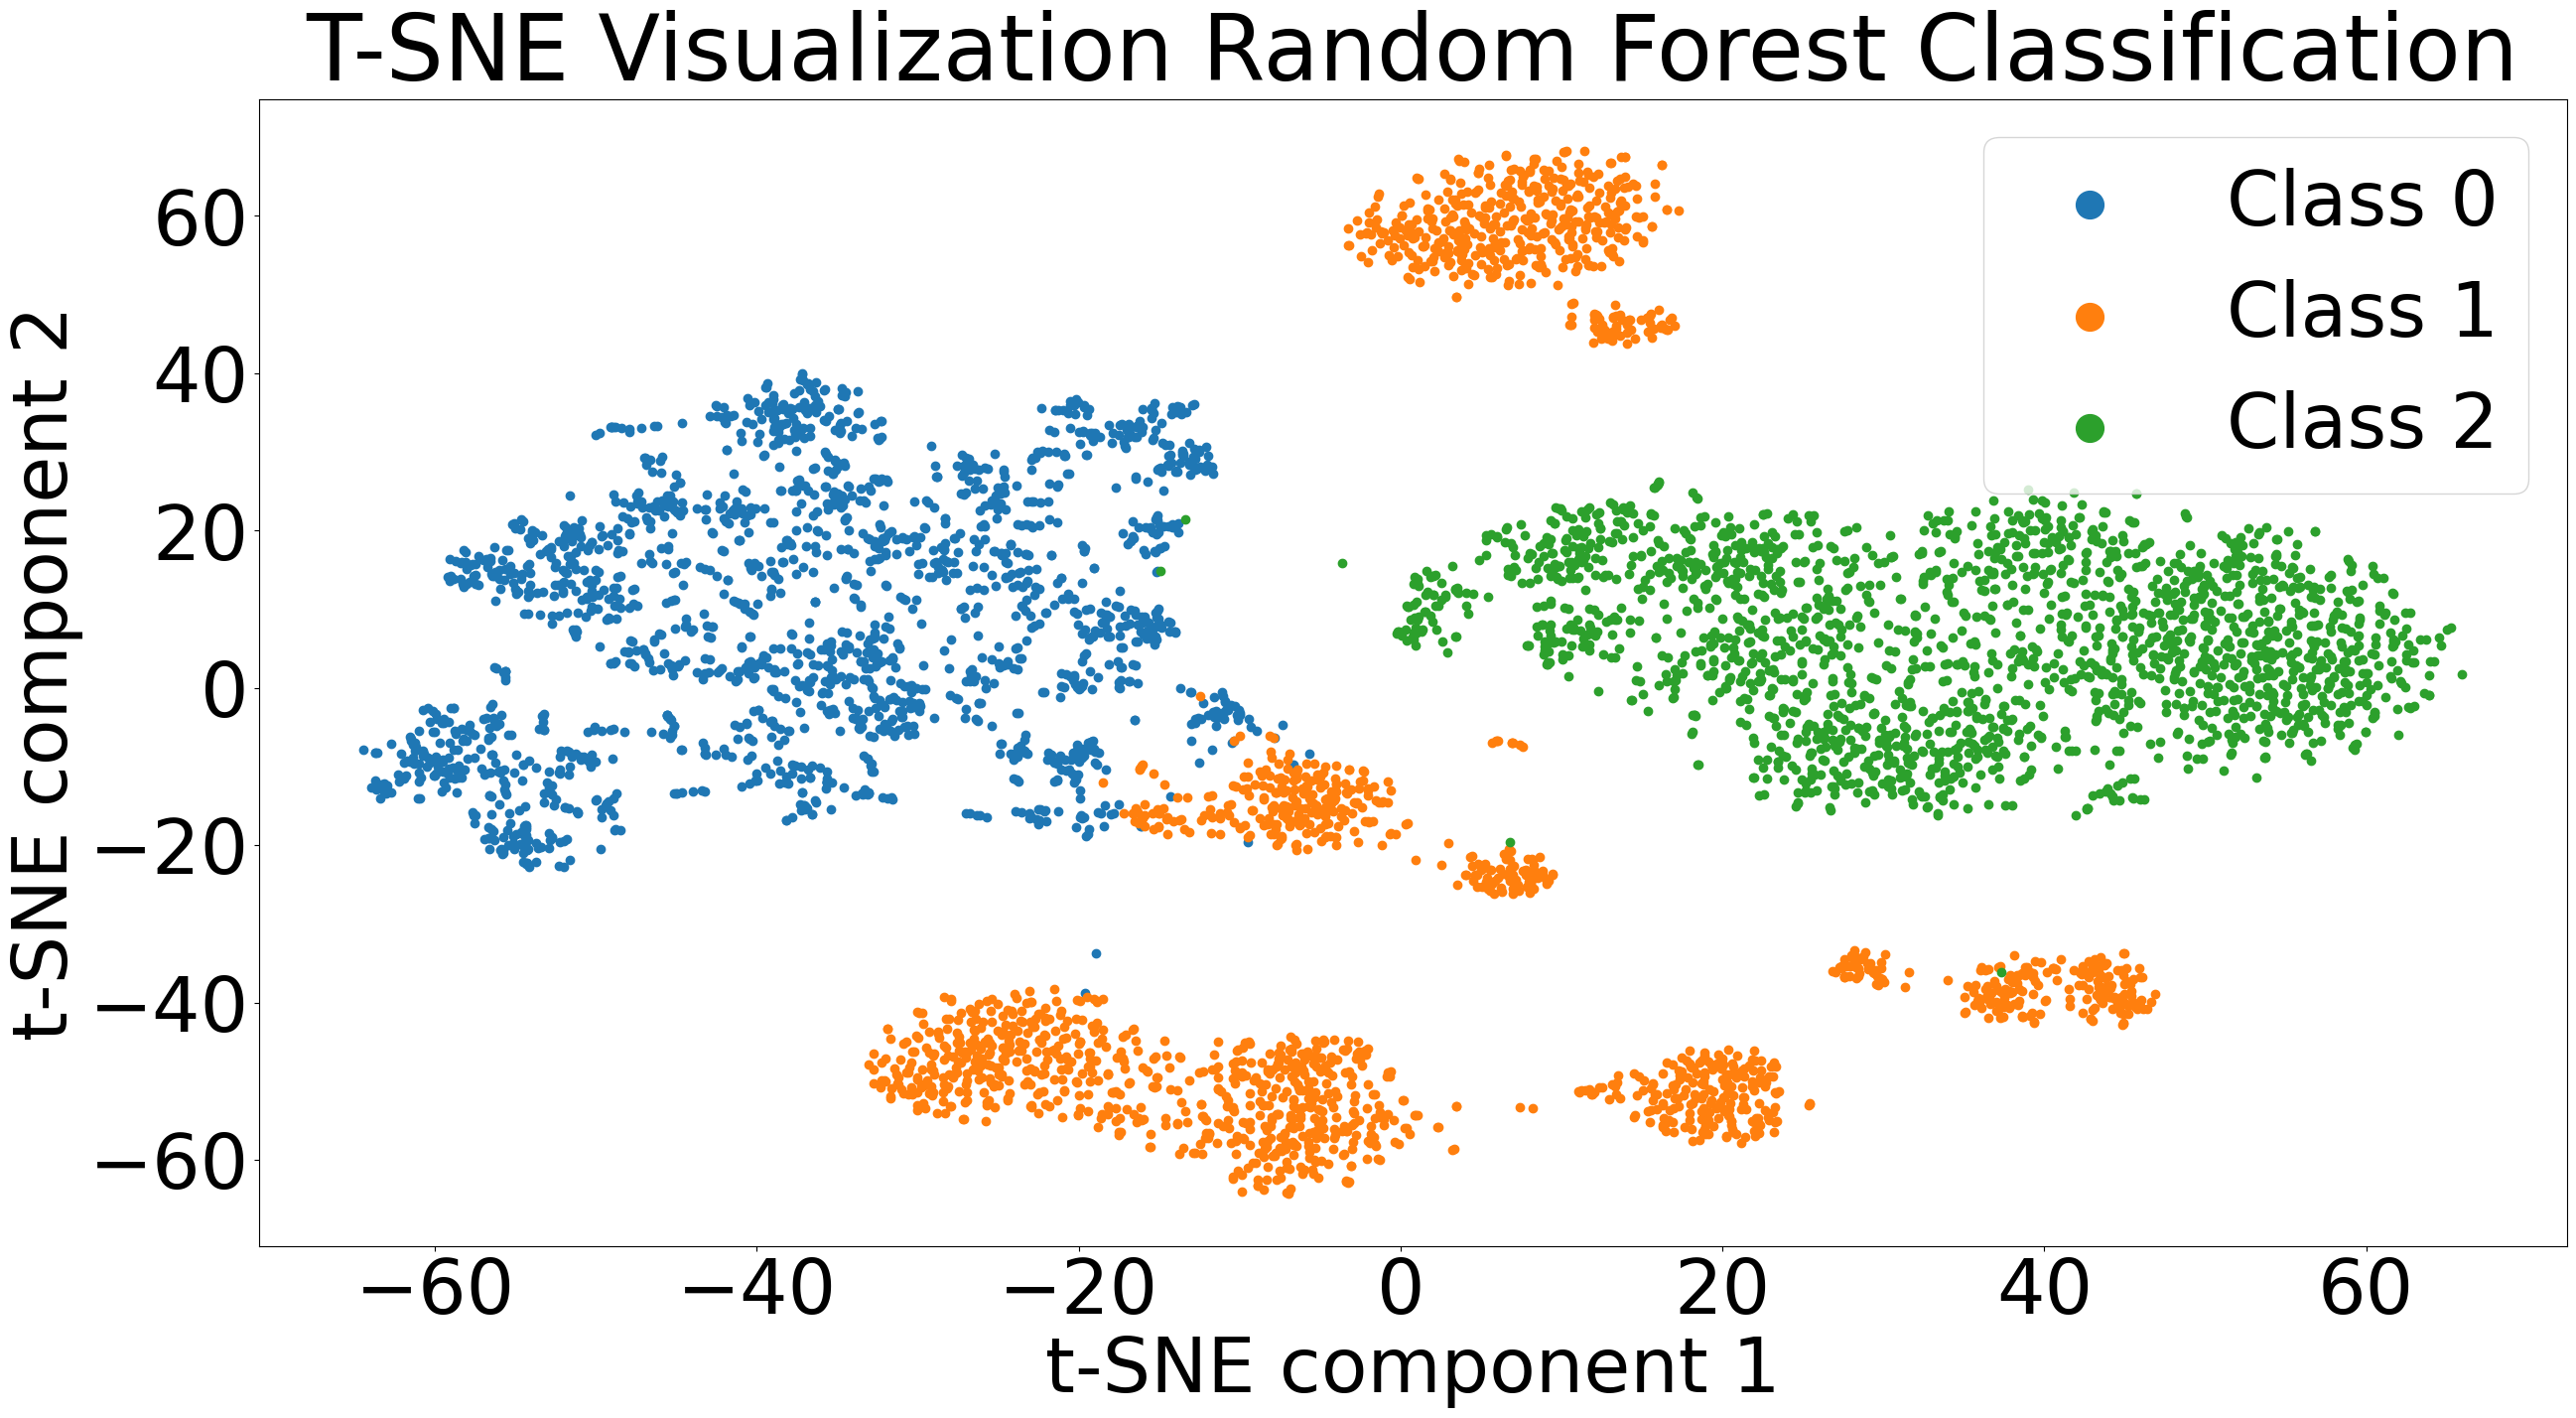

In [58]:
#Make a scatter plot with X_embedded
#TODO: Define the TSNE and transform your data into a 2D embedding space
plt.rcParams.update({'font.size': 55})
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

classes=list(set(y))
plt.figure(figsize=(30, 15))

for cl in classes:
    indices = np.where(y==cl)[0]
    plt.title('T-SNE Visualization Random Forest Classification')
    plt.scatter(X_embedded[indices,0], X_embedded[indices, 1], label=f'Class {int(cl)}')
    plt.ylabel('t-SNE component 2')
    plt.xlabel('t-SNE component 1')

legend = plt.legend()
for handle in legend.legend_handles:
        handle.set_sizes([400])
plt.rcParams.update({'font.size': 10})